# # Import all the libraries

In [12]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
import glob
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

## Read all the CSV files.

In [13]:
path_Ecu1 = "D:\Dataset\CAN1_2m_Thin_uns1\*.csv"
path_Ecu2 = "D:\Dataset\CAN2_6m_Thin_uns1\*.csv"
path_Ecu3 = "D:\Dataset\CAN3_10m_Thin_uns1\*.csv"
path_Ecu4 = "D:\Dataset\CAN5_2m_Thick_uns1\*.csv"
path_Ecu5 = "D:\Dataset\CAN6_6m_Thick_uns1\*.csv"
path_Ecu6 = "D:\Dataset\CAN91_2m_Silver_uns1\*.csv"
path_Ecu7 = "D:\Dataset\CAN92_6m_Silver_uns1\*.csv"
path_Ecu8 = "D:\Dataset\CAN93_10m_Silver_uns1\*.csv"

## Create class Ecu_Can_Message that will create feature sets for each ECUs as an output. The output features include Peak Voltage, percent overshoot, Steady State Vss, Settling Time, Highest Voltage, Lowest Voltage, Settling Time Max.

In [14]:
class Ecu_Can_Message:
    def __init__(self, path):
        self.path = path
        self.EcuPeakTime = []
        self.EcuSettlingTime = []
        self.EcuSteadyStateVss = []
        self.waveSettlingTimeMax = []
        self.waveSettlingTimeMin = []
        self.actualWavePeakVoltage = []
        self.actualWaveLowVoltage = []
        self.Ecu_Can_Volt_List = []
        self.Ecu_Expected_volt_List = []
        self.Ecu_Time_Us_List = []
        self.FourierList = []
        self.PeakFreq = []
        self.LeastFreq = []
        self.PeakFreqAmplitude =[]
        self.LeastFreqAmplitude = []
    
    def getPeakTime(self):
        return (self.EcuPeakTime)
    
    def getSettlingTime(self):
        return (self.EcuSettlingTime)
    
    def getEcuSteadyStateVss(self):
        return (self.EcuSteadyStateVss)
    
    def getSettlingTimeMax(self):
        return (self.waveSettlingTimeMax)
    
    def getSettlingTimeMin(self):
        return (self.waveSettlingTimeMin)
    
    def getPeakVoltage(self):
        return (self.actualWavePeakVoltage)
    
    def getLowestVoltage(self):
        return (self.actualWaveLowVoltage)    
    
    def getVoltage(self):
        return (self.Ecu_Can_Volt_List)
    
    def getExpectedVoltage(self):
        return (self.Ecu_Expected_volt_List)
    
    def getTimeUs(self):
        return (self.Ecu_Time_Us_List)
    
    def getFourierSignal(self):
        return (self.FourierList)
    
    def getPeakFreq(self):
        return(self.PeakFreq)
    
    def getLeastFreq(self):
        return(self.LeastFreq)

    def getPeakFreqAmplitude(self):
        return(self.PeakFreqAmplitude)
    
    def getLeastFreqAmplitude(self):
        return(self.LeastFreqAmplitude)
    
    def ReadCsv(self):
        Ecu_can_volt_data_List = []
        for file_name in glob.glob(self.path):
            wave_voltage = pd.read_csv(file_name)
            Ecu_can_volt_data_List.append(list(wave_voltage.columns))
        return Ecu_can_volt_data_List
        
    def ColumnListToFloatArray(self, Ecu_Can_Aauns_ColumnList):
        Ecu_Can_Aauns_List = []
        for i in range(len(Ecu_Can_Aauns_ColumnList)):
            if (len(Ecu_Can_Aauns_ColumnList[i]) > 3):
                if (Ecu_Can_Aauns_ColumnList[i][3] == '.'):
                    Ecu_Can_Aauns_List.append('{:.3}'.format(Ecu_Can_Aauns_ColumnList[i]))
                else:
                    Ecu_Can_Aauns_List.append('{:.4}'.format(Ecu_Can_Aauns_ColumnList[i]))
            else:
                Ecu_Can_Aauns_List.append(Ecu_Can_Aauns_ColumnList[i])

        Ecu_Can_Aauns_Array = np.array(Ecu_Can_Aauns_List)
        Ecu_Can_Aauns_Array = np.array([float(numeric_string) for numeric_string in Ecu_Can_Aauns_Array])    
        return Ecu_Can_Aauns_Array

    def ExpectedValue(self, Ecu_Can_Aauns_Array):
        ExpectedValueList = []
        for can_high_volt in Ecu_Can_Aauns_Array:
            if can_high_volt >= 3.0:
                ExpectedValueList.append(3.50)
            else:
                ExpectedValueList.append(2.50)
        return (np.array(ExpectedValueList))

    def TimeUs(self, Ecu_Can_Aauns_Array):
        time_us = []
        for i in range(Ecu_Can_Aauns_Array.shape[0]):
            time_us.append(i)
            i = i + 1
        return (np.array(time_us))

    def DetectRisingFallingEdgeIndex(self, Ecu_Expected_volt_Array):
        rising_edge = []
        falling_edge = []
        for i in range(len(Ecu_Expected_volt_Array)):
            if(i != Ecu_Expected_volt_Array.shape[0] - 5):
                if ((Ecu_Expected_volt_Array[i] == 2.5) and (Ecu_Expected_volt_Array[i+1] == 3.5) 
                            and (Ecu_Expected_volt_Array[i+2] == 3.5) and (Ecu_Expected_volt_Array[i+3] == 3.5)
                            and (Ecu_Expected_volt_Array[i+4] == 3.5) and (Ecu_Expected_volt_Array[i+5] == 3.5)):
                    rising_edge.append(i)
                elif ((Ecu_Expected_volt_Array[i] == 3.5) and (Ecu_Expected_volt_Array[i+1] == 2.5) 
                              and (Ecu_Expected_volt_Array[i+2] == 2.5) and (Ecu_Expected_volt_Array[i+3] == 2.5)
                              and (Ecu_Expected_volt_Array[i+4] == 2.5) and (Ecu_Expected_volt_Array[i+5] == 2.5)):
                    falling_edge.append(i)
            else:
                break
        if rising_edge[0]>falling_edge[0]:
            falling_edge.pop(0)
            falling_edge.append(Ecu_Expected_volt_Array.shape[0]-1)    
        if (len(rising_edge) > len(falling_edge)):
            falling_edge.append(Ecu_Expected_volt_Array.shape[0])
        elif (len(falling_edge) > len(rising_edge)):
            falling_edge.pop()
        return rising_edge, falling_edge
    
    def HighLowVoltage(self, squareWaveActual):
        highVoltageList = []
        lowVoltageList = []
        for wave in squareWaveActual:
            highVoltageList.append(wave[np.argmax(wave)])
            lowVoltageList.append(wave[np.argmin(wave)])
        return highVoltageList, lowVoltageList

    def FFTVoltage(self, squareWaveActual):
        freqVoltageList = []
        for wave in squareWaveActual:
            freqVoltageList.append(np.absolute(fft(wave)))
        return freqVoltageList
    
    def FFTFeatures(self, fftVoltage):
        peakFrequency = []
        leastFrequency = []
        peakAmplitude = []
        leastAmplitude = []
        for freq in fftVoltage:
            peakFrequency.append(np.argmax(freq[1:]))
            leastFrequency.append(np.argmin(freq[1:]))
            peakAmplitude.append(freq[np.argmax(freq[1:])])
            leastAmplitude.append(freq[np.argmin(freq[1:])])
        return peakFrequency, leastFrequency, peakAmplitude, leastAmplitude
    
    
    def PeakTime(self, squareWaveActual, squareWaveTime):
        peakTimeindex = 0
        peakTimeTp = []
        peakVoltage = []
        for wave, waveTime in zip(squareWaveActual,squareWaveTime):
            peakTimeindex = np.argmax(np.array(wave))
            peakTimeTp.append(waveTime[peakTimeindex] - waveTime[0])
        return peakTimeTp
    

    def PercentOvershoot(self, squareWaveActual):
        peakValue = 0
        percentOvershootList = []
        for wave in squareWaveActual:
            peakValue = wave[np.argmax(np.array(wave))]
            percentOvershootList.append(round(((peakValue - 3.5)/3.5) * 100, 4))
        return percentOvershootList

    def SettlingTime(self, squareWaveActual, squareWaveTime):
        ErrorRange = 0.05 * 3.5
        Maxrange_Volt = 3.5 + ErrorRange
        MinRange_Volt = 3.5 - ErrorRange
        timeIndex = 0
        minRangeindex = 0
        maxRangeindex = 0
        settlingTimeList = []
        settlingTimemaxList = []
        settlingTimeminList = []
        for wave, waveTime in zip(squareWaveActual, squareWaveTime):
            for i in range(len(wave)):
                if (wave[i] > Maxrange_Volt):
                    maxRangeindex = i 
                elif (wave[i] < MinRange_Volt):
                    minRangeindex = i
            settlingTimemaxList.append(waveTime[maxRangeindex] - waveTime[0])
            settlingTimeminList.append(waveTime[minRangeindex] - waveTime[0])
            if (minRangeindex>maxRangeindex):
                timeIndex = minRangeindex
            else:
                timeIndex= maxRangeindex
            settlingTimeList.append(waveTime[timeIndex] - waveTime[0]) 
        return settlingTimeList, settlingTimemaxList, settlingTimeminList

    def SteadyStateValue(self, squareWaveTime):
        steadyStateValueList = []
        for wave in squareWaveTime:
            steadyStateValueList.append((max(list(wave), key = list(wave).count)))
        return steadyStateValueList

    def ConvertCanMessageToParameter(self):
        Squared_wave_actual_List = []
        Squared_wave_expected_List = []
        Square_wave_time_List = []
        
        for can_volt in self.ReadCsv():
            self.Ecu_Can_Volt_List.append(self.ColumnListToFloatArray(can_volt))
        
        
            
        for actual_can_volt in self.Ecu_Can_Volt_List:
            self.Ecu_Expected_volt_List.append(self.ExpectedValue(actual_can_volt))
            self.Ecu_Time_Us_List.append(self.TimeUs(actual_can_volt))
        
        for actual_can_volt, expected_can_volt, time_us in zip(self.Ecu_Can_Volt_List, self.Ecu_Expected_volt_List, self.Ecu_Time_Us_List):
            rising_edge_list, falling_edge_list = self.DetectRisingFallingEdgeIndex(expected_can_volt)
            for i in range(len(rising_edge_list)):
                Squared_wave_actual_List.append(actual_can_volt[rising_edge_list[i]:falling_edge_list[i]])
                Squared_wave_expected_List.append(expected_can_volt[rising_edge_list[i]:falling_edge_list[i]])
                Square_wave_time_List.append(time_us[rising_edge_list[i]:falling_edge_list[i]])
        
        self.FourierList = self.FFTVoltage(Squared_wave_actual_List)
        PeakTimeTp = self.PeakTime(Squared_wave_actual_List, Square_wave_time_List)
        PercentOvershootOs = self.PercentOvershoot(Squared_wave_actual_List)
        SettlingTimeTs, SettlingTimeMax, SettlingTimeMin = self.SettlingTime(Squared_wave_actual_List, Square_wave_time_List)
        SteadyStateValueVss = self.SteadyStateValue(Squared_wave_actual_List)
        HighestVoltage, LowestVoltage = self.HighLowVoltage(Squared_wave_actual_List)
        PeakFrequency, LeastFrequency, PeakAmplitude, LeastAmplitude = self.FFTFeatures(self.FourierList)
        
        self.EcuPeakTime = PeakTimeTp
        self.EcuSettlingTime = SettlingTimeTs
        self.EcuSteadyStateVss = SteadyStateValueVss
        self.waveSettlingTimeMax = SettlingTimeMax
        self.waveSettlingTimeMin = SettlingTimeMin
        self.actualWavePeakVoltage = HighestVoltage
        self.actualWaveLowVoltage = LowestVoltage
        self.PeakFreq = PeakFrequency
        self.LeastFreq = LeastFrequency
        self.PeakFreqAmplitude = PeakAmplitude
        self.LeastFreqAmplitude = LeastAmplitude
        
        Ecu_Identification_Array = np.array([0 for element in range(len(PeakTimeTp))])
        if (self.path == path_Ecu1):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 1)
        elif (self.path == path_Ecu2):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 2)
        elif (self.path == path_Ecu3):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 3)
        elif (self.path == path_Ecu4):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 4)
        elif (self.path == path_Ecu5):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 5)    
        elif (self.path == path_Ecu6):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 6)    
        elif (self.path == path_Ecu7):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 7)    
        elif (self.path == path_Ecu8):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 8)
            
        Ecu_Data_Array = np.vstack((np.array(PeakTimeTp), np.array(PercentOvershootOs), 
                                    np.array(SettlingTimeTs), np.array(SteadyStateValueVss), 
                                    np.array(SettlingTimeMax), np.array(HighestVoltage), 
                                    np.array(LowestVoltage), np.array(PeakFrequency),
                                    np.array(LeastFrequency)))#,np.array(PeakAmplitude), np.array(LeastAmplitude)))
        
        Ecu_Data_Array = np.c_[Ecu_Data_Array.T, Ecu_Identification_Array]
        return Ecu_Data_Array  
       

### New Class is created to simulate the intrusion signal inherited from class Ecu_Can_Message above. Following class will take any ECU signal as input and adds gaussian noise to simulate intruded signal.

In [15]:
class Ecu_Can_Message_With_Noise(Ecu_Can_Message):
    def __init__(self,path):
        super().__init__(path)
        self.Ecu_Can_Volt_Noise_List = []

    def getVoltage(self):
        return(self.Ecu_Can_Volt_Noise_List)
    
    def AddNoise(self, Ecu_Can_Voltage_Array):
        mu = 0
        sigma = 0.1
        noise = np.random.normal(mu,sigma,np.array(Ecu_Can_Voltage_Array).shape) #[599,]
        return (Ecu_Can_Voltage_Array + noise)
    
    def AddSPNoise(self, Ecu_Can_Voltage_Array):
        mu = 0
        sigma = 0.09
        noise = np.random.normal(mu,sigma,np.array(Ecu_Can_Voltage_Array).shape) #[599,]
        s_noise = (noise>0.9*sigma)
        p_noise = (noise<-0.9*sigma)
        sp_noise = s_noise + p_noise
        return (Ecu_Can_Voltage_Array + sp_noise)
    
    def ConvertCanMessageToParameter(self):
        Squared_wave_actual_List = []
        Squared_wave_expected_List = []
        Square_wave_time_List = []      
        
        for can_volt in self.ReadCsv():
            self.Ecu_Can_Volt_List.append(self.ColumnListToFloatArray(can_volt))        
        
#         self.Ecu_Can_Volt_Noise_List = self.AddSPNoise(self.Ecu_Can_Volt_List)
        
        self.Ecu_Can_Volt_Noise_List = self.AddNoise(self.Ecu_Can_Volt_List)
            
        for actual_can_volt in self.Ecu_Can_Volt_List:
            self.Ecu_Expected_volt_List.append(self.ExpectedValue(actual_can_volt))
            self.Ecu_Time_Us_List.append(self.TimeUs(actual_can_volt))
        
        for actual_can_volt, expected_can_volt, time_us in zip(self.Ecu_Can_Volt_Noise_List, self.Ecu_Expected_volt_List, self.Ecu_Time_Us_List):
            rising_edge_list, falling_edge_list = self.DetectRisingFallingEdgeIndex(expected_can_volt)
            for i in range(len(rising_edge_list)):
                Squared_wave_actual_List.append(actual_can_volt[rising_edge_list[i]:falling_edge_list[i]])
                Squared_wave_expected_List.append(expected_can_volt[rising_edge_list[i]:falling_edge_list[i]])
                Square_wave_time_List.append(time_us[rising_edge_list[i]:falling_edge_list[i]])
        
        self.FourierList = self.FFTVoltage(Squared_wave_actual_List)
        PeakTimeTp = self.PeakTime(Squared_wave_actual_List, Square_wave_time_List)
        PercentOvershootOs = self.PercentOvershoot(Squared_wave_actual_List)
        SettlingTimeTs, SettlingTimeMax, SettlingTimeMin = self.SettlingTime(Squared_wave_actual_List, Square_wave_time_List)
        SteadyStateValueVss = self.SteadyStateValue(Squared_wave_actual_List)        
        HighestVoltage, LowestVoltage = self.HighLowVoltage(Squared_wave_actual_List)
        PeakFrequency, LeastFrequency, PeakAmplitude, LeastAmplitude = self.FFTFeatures(self.FourierList)
        
        self.EcuPeakTime = PeakTimeTp
        self.EcuSettlingTime = SettlingTimeTs
        self.EcuSteadyStateVss = SteadyStateValueVss
        self.waveSettlingTimeMax = SettlingTimeMax
        self.waveSettlingTimeMin = SettlingTimeMin
        self.actualWavePeakVoltage = HighestVoltage
        self.actualWaveLowVoltage = LowestVoltage
        self.PeakFreq = PeakFrequency
        self.LeastFreq = LeastFrequency
        self.PeakFreqAmplitude = PeakAmplitude
        self.LeastFreqAmplitude = LeastAmplitude
        
        Ecu_Identification_Array = np.array([0 for element in range(len(PeakTimeTp))])
        if (self.path == path_Ecu1):
            Ecu_Identification_Array = np.full((len(PeakTimeTp),1), 9)
            
        Ecu_Data_Array = np.vstack((np.array(PeakTimeTp), np.array(PercentOvershootOs), 
                                    np.array(SettlingTimeTs), np.array(SteadyStateValueVss), 
                                    np.array(SettlingTimeMax), np.array(HighestVoltage), 
                                    np.array(LowestVoltage), np.array(PeakFrequency),
                                    np.array(LeastFrequency)))#,np.array(PeakAmplitude),np.array(LeastAmplitude)))
        
        Ecu_Data_Array = np.c_[Ecu_Data_Array.T, Ecu_Identification_Array]
        return Ecu_Data_Array

## Create object for each ECU by passing path for each CSV file as an input as parameter.

In [16]:
Ecu1 = Ecu_Can_Message(path_Ecu1)
Ecu2 = Ecu_Can_Message(path_Ecu2)
Ecu3 = Ecu_Can_Message(path_Ecu3)
Ecu4 = Ecu_Can_Message(path_Ecu4)
Ecu5 = Ecu_Can_Message(path_Ecu5)
Ecu6 = Ecu_Can_Message(path_Ecu6)
Ecu7 = Ecu_Can_Message(path_Ecu7)
Ecu8 = Ecu_Can_Message(path_Ecu8)

# ECU9 represents intrusion signal. The signal is created by adding Gaussian noise in ECU 1 signal.
Ecu9 = Ecu_Can_Message_With_Noise(path_Ecu1)

## Call ConvertCanMessageToParameter() function for each ECU to provide all feature set as column.

In [17]:
Ecu1_data = Ecu1.ConvertCanMessageToParameter()
Ecu2_data = Ecu2.ConvertCanMessageToParameter()
Ecu3_data = Ecu3.ConvertCanMessageToParameter()
Ecu4_data = Ecu4.ConvertCanMessageToParameter()
Ecu5_data = Ecu5.ConvertCanMessageToParameter()
Ecu6_data = Ecu6.ConvertCanMessageToParameter()
Ecu7_data = Ecu7.ConvertCanMessageToParameter()
Ecu8_data = Ecu8.ConvertCanMessageToParameter()
Ecu9_data = Ecu9.ConvertCanMessageToParameter()
# Ecu10_data = Ecu10.ConvertCanMessageToParameter()

## Stack all ECU data to create a single data set. Seven columns are for the feature set and seperate the ECU identification column.

In [18]:
EcuData = np.vstack((Ecu1_data, Ecu2_data, Ecu3_data, Ecu4_data, Ecu5_data, Ecu6_data, Ecu7_data, Ecu8_data, Ecu9_data))
# EcuData = np.vstack((Ecu1_data, Ecu2_data, Ecu3_data, Ecu4_data, Ecu5_data, Ecu6_data, Ecu7_data, Ecu8_data))
np.random.shuffle(EcuData)
EcuDataArray = EcuData[:,:-1]
EcuIdentification = EcuData[:,-1]

## Create 80% training set and 20% test set at first. Then from the 80% training set, create 10% validation set.

In [19]:
EcuDataArray_train, EcuDataArray_test, EcuIdentification_train, EcuIdentification_test = train_test_split(
                                                                                                EcuDataArray, 
                                                                                                EcuIdentification, 
                                                                                                test_size = 0.2, 
                                                                                                random_state = 42)

EcuDataArray_train, EcuDataArray_Val, EcuIdentification_train, EcuIdentification_Val = train_test_split(
                                                                                                EcuDataArray_train, 
                                                                                                EcuIdentification_train, 
                                                                                                test_size = 0.1, 
                                                                                                random_state = 42)

In [20]:
print(EcuDataArray.shape)
print(EcuDataArray_train.shape)
print(EcuDataArray_test.shape)
print(EcuDataArray_Val.shape)

(1333, 9)
(959, 9)
(267, 9)
(107, 9)


## Use Standard Scaler python library to scale all training, test and validation set.

In [335]:
scaler = StandardScaler()
EcuDataArray_TrainScaled = scaler.fit_transform(EcuDataArray_train)
EcuDataArray_TestScaled = scaler.transform(EcuDataArray_test)
EcuDataArray_ValScaled = scaler.transform(EcuDataArray_Val)

## Use Gaussian Naive Bayes algorithm to model the data and find the accuracy and Confusion matrix.

Accuracy of train set using Gaussian Naive Bayes:: 0.8248175182481752
Accuracy of test set using Gaussian Naive Bayes: 0.7940074906367042


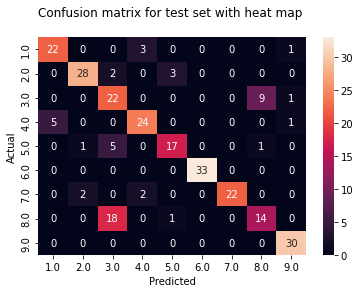

In [336]:
gb = GaussianNB()
gb.fit(EcuDataArray_TrainScaled, EcuIdentification_train)
EcuIdentification_Test_pred = gb.predict(EcuDataArray_TestScaled)
EcuIdentification_Train_pred = gb.predict(EcuDataArray_TrainScaled)

print("Accuracy of train set using Gaussian Naive Bayes::", metrics.accuracy_score(EcuIdentification_train, EcuIdentification_Train_pred))
print("Accuracy of test set using Gaussian Naive Bayes:", metrics.accuracy_score(EcuIdentification_test, EcuIdentification_Test_pred))

# Confusion matrix of test set.
confusion_matrix = pd.crosstab(EcuIdentification_test, EcuIdentification_Test_pred, rownames=['Actual'], colnames=['Predicted'])
ax = sns.heatmap(confusion_matrix, annot=True)
ax.set(title = 'Confusion matrix for test set with heat map \n')

plt.show()

## Create classification report of Gaussian Naive Bayes model.

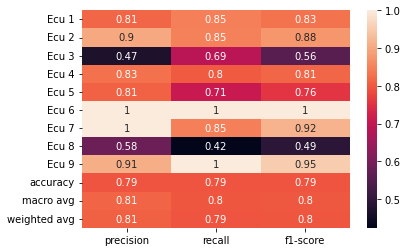

In [337]:
target_names = ["Ecu 1", "Ecu 2", "Ecu 3", "Ecu 4", "Ecu 5", "Ecu 6", "Ecu 7", "Ecu 8", "Ecu 9"]
# target_names = ["Ecu 1", "Ecu 2", "Ecu 3", "Ecu 4", "Ecu 5", "Ecu 6", "Ecu 7", "Ecu 8"]
clf_report_gnb = classification_report(EcuIdentification_test, EcuIdentification_Test_pred, 
                                   target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_gnb). iloc[:-1, :].T, annot=True)
plt.show()

## Use Random forest algorithm to model the data and find the accuracy and Confusion matrix.

Accuracy of train set using Random Forest: 0.9363920750782064
Accuracy of test set using Random Forest: 0.8389513108614233


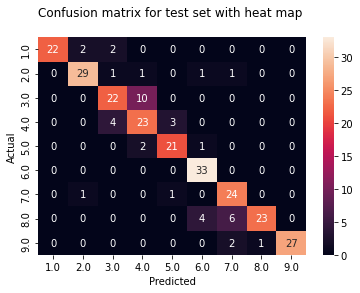

In [338]:
forest_reg = RandomForestRegressor()
forest_reg.fit(EcuDataArray_TrainScaled, EcuIdentification_train)
EcuIdentification_test_pred_forest = forest_reg.predict(EcuDataArray_TestScaled)
EcuIdentification_train_pred_forest = forest_reg.predict(EcuDataArray_TrainScaled)

print("Accuracy of train set using Random Forest:", metrics.accuracy_score(EcuIdentification_train, np.round(EcuIdentification_train_pred_forest)))
print("Accuracy of test set using Random Forest:", metrics.accuracy_score(EcuIdentification_test, np.round(EcuIdentification_test_pred_forest)))

# Confusion matrix of test set.
confusion_matrix = pd.crosstab(EcuIdentification_test, np.round(EcuIdentification_test_pred_forest), rownames=['Actual'], colnames=['Predicted'])
ax = sns.heatmap(confusion_matrix, annot=True)
ax.set(title = 'Confusion matrix for test set with heat map \n')
plt.show()

## Create classification report of Random forest model.

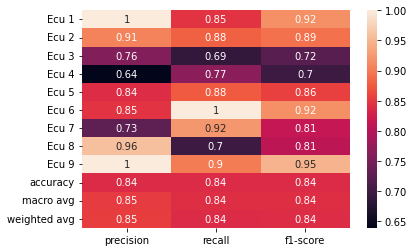

In [339]:
target_names = ["Ecu 1", "Ecu 2", "Ecu 3", "Ecu 4", "Ecu 5", "Ecu 6", "Ecu 7", "Ecu 8", "Ecu 9"]
# target_names = ["Ecu 1", "Ecu 2", "Ecu 3", "Ecu 4", "Ecu 5", "Ecu 6", "Ecu 7", "Ecu 8"]
clf_report_forest = classification_report(EcuIdentification_test, np.round(EcuIdentification_test_pred_forest), 
                                   target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_forest). iloc[:-1, :].T, annot=True)
plt.show()

## Buid neural network skeleton to find the optimal number of hidden layers and number of neurons to be used in the hidden layer. The input size if [1,7] with 7 representing all seven features.

In [385]:
# def build_model(n_hidden=4 , n_neurons=50, learning_rate=3e-3, input_shape= (None, 1, 9)):
#     model = keras.models.Sequential()
#     for layer in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation="tanh"))
#     model.add(keras.layers.Dense(10, activation="softmax"))
# #     model.add(keras.layers.Dense(10, activation="softmax"))
#     optimizer = keras.optimizers.SGD(lr=learning_rate)
#     model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
#     return model

# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# keras_reg.fit(EcuDataArray_TrainScaled, EcuIdentification_train,epochs=500,
#               validation_data=(EcuDataArray_ValScaled, EcuIdentification_Val),
#              callbacks=[keras.callbacks.EarlyStopping(patience=10)])
# mse_test = keras_reg.score(EcuDataArray_TestScaled, EcuIdentification_test)


Epoch 1/500
30/30 [==============================] - 0s 4ms/step - loss: 2.2720 - val_loss: 2.1390
Epoch 2/500
30/30 [==============================] - 0s 2ms/step - loss: 2.1535 - val_loss: 2.0330
Epoch 3/500
30/30 [==============================] - 0s 2ms/step - loss: 2.0509 - val_loss: 1.9410
Epoch 4/500
30/30 [==============================] - 0s 1ms/step - loss: 1.9607 - val_loss: 1.8604
Epoch 5/500
30/30 [==============================] - 0s 2ms/step - loss: 1.8812 - val_loss: 1.7895
Epoch 6/500
30/30 [==============================] - 0s 2ms/step - loss: 1.8104 - val_loss: 1.7264
Epoch 7/500
30/30 [==============================] - 0s 2ms/step - loss: 1.7465 - val_loss: 1.6699
Epoch 8/500
30/30 [==============================] - 0s 1ms/step - loss: 1.6889 - val_loss: 1.6191
Epoch 9/500
30/30 [==============================] - 0s 1ms/step - loss: 1.6362 - val_loss: 1.5730
Epoch 10/500
30/30 [==============================] - 0s 2ms/step - loss: 1.5878 - val_loss: 1.5309
Epoch 11/

30/30 [==============================] - 0s 2ms/step - loss: 0.7286 - val_loss: 0.7868
Epoch 84/500
30/30 [==============================] - 0s 1ms/step - loss: 0.7247 - val_loss: 0.7829
Epoch 85/500
30/30 [==============================] - 0s 2ms/step - loss: 0.7209 - val_loss: 0.7794
Epoch 86/500
30/30 [==============================] - 0s 2ms/step - loss: 0.7173 - val_loss: 0.7758
Epoch 87/500
30/30 [==============================] - 0s 2ms/step - loss: 0.7136 - val_loss: 0.7723
Epoch 88/500
30/30 [==============================] - 0s 2ms/step - loss: 0.7100 - val_loss: 0.7689
Epoch 89/500
30/30 [==============================] - 0s 2ms/step - loss: 0.7064 - val_loss: 0.7652
Epoch 90/500
30/30 [==============================] - 0s 1ms/step - loss: 0.7029 - val_loss: 0.7618
Epoch 91/500
30/30 [==============================] - 0s 1ms/step - loss: 0.6994 - val_loss: 0.7583
Epoch 92/500
30/30 [==============================] - 0s 1ms/step - loss: 0.6959 - val_loss: 0.7548
Epoch 93/500


30/30 [==============================] - 0s 1ms/step - loss: 0.4103 - val_loss: 0.4488
Epoch 246/500
30/30 [==============================] - 0s 1ms/step - loss: 0.4093 - val_loss: 0.4477
Epoch 247/500
30/30 [==============================] - 0s 2ms/step - loss: 0.4082 - val_loss: 0.4465
Epoch 248/500
30/30 [==============================] - 0s 1ms/step - loss: 0.4073 - val_loss: 0.4453
Epoch 249/500
30/30 [==============================] - 0s 2ms/step - loss: 0.4063 - val_loss: 0.4441
Epoch 250/500
30/30 [==============================] - 0s 1ms/step - loss: 0.4053 - val_loss: 0.4430
Epoch 251/500
30/30 [==============================] - 0s 1ms/step - loss: 0.4042 - val_loss: 0.4419
Epoch 252/500
30/30 [==============================] - 0s 2ms/step - loss: 0.4032 - val_loss: 0.4406
Epoch 253/500
30/30 [==============================] - 0s 1ms/step - loss: 0.4024 - val_loss: 0.4393
Epoch 254/500
30/30 [==============================] - 0s 2ms/step - loss: 0.4015 - val_loss: 0.4382
Epoc

30/30 [==============================] - 0s 1ms/step - loss: 0.2965 - val_loss: 0.3261
Epoch 408/500
30/30 [==============================] - 0s 2ms/step - loss: 0.2959 - val_loss: 0.3258
Epoch 409/500
30/30 [==============================] - 0s 1ms/step - loss: 0.2954 - val_loss: 0.3254
Epoch 410/500
30/30 [==============================] - 0s 1ms/step - loss: 0.2947 - val_loss: 0.3251
Epoch 411/500
30/30 [==============================] - 0s 2ms/step - loss: 0.2947 - val_loss: 0.3247
Epoch 412/500
30/30 [==============================] - 0s 1ms/step - loss: 0.2941 - val_loss: 0.3243
Epoch 413/500
30/30 [==============================] - 0s 2ms/step - loss: 0.2935 - val_loss: 0.3239
Epoch 414/500
30/30 [==============================] - 0s 2ms/step - loss: 0.2930 - val_loss: 0.3234
Epoch 415/500
30/30 [==============================] - 0s 1ms/step - loss: 0.2925 - val_loss: 0.3230
Epoch 416/500
30/30 [==============================] - 0s 1ms/step - loss: 0.2919 - val_loss: 0.3227
Epoc

## Used Randomized Search CV on the neural network skeleton build above to find the optimal number of hidden layers and number of neurons in the hidden layers.

In [389]:
# from sklearn.model_selection import RandomizedSearchCV

# param_distribs = {
#     "n_hidden": [1,2,3,4,5],
#     "n_neurons": np.arange(1,100).tolist(),
#     "learning_rate": [0.1, 0.01, 0.001, 0.0001]
# }

# rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
# rnd_search_cv.fit(EcuDataArray_TrainScaled, EcuIdentification_train,epochs=200,
#                   validation_data=(EcuDataArray_ValScaled, EcuIdentification_Val),
#              callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/200
20/20 [==============================] - 0s 6ms/step - loss: 2.2963 - val_loss: 2.3149
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2069 - val_loss: 2.2307
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1287 - val_loss: 2.1558
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0592 - val_loss: 2.0883
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9960 - val_loss: 2.0268
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9384 - val_loss: 1.9701
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8847 - val_loss: 1.9175
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8349 - val_loss: 1.8684
Epoch 9/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7879 - val_loss: 1.8224
Epoch 10/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7438 - val_loss: 1.7793
Epoch 11/

20/20 [==============================] - 0s 2ms/step - loss: 0.7557 - val_loss: 0.8778
Epoch 84/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7515 - val_loss: 0.8729
Epoch 85/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7467 - val_loss: 0.8684
Epoch 86/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7426 - val_loss: 0.8638
Epoch 87/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7380 - val_loss: 0.8595
Epoch 88/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7339 - val_loss: 0.8551
Epoch 89/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7298 - val_loss: 0.8505
Epoch 90/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7251 - val_loss: 0.8459
Epoch 91/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7207 - val_loss: 0.8407
Epoch 92/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7167 - val_loss: 0.8359
Epoch 93/200


20/20 [==============================] - 0s 2ms/step - loss: 1.1047 - val_loss: 1.1896
Epoch 46/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0928 - val_loss: 1.1790
Epoch 47/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0807 - val_loss: 1.1687
Epoch 48/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0696 - val_loss: 1.1586
Epoch 49/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0585 - val_loss: 1.1489
Epoch 50/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0479 - val_loss: 1.1395
Epoch 51/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0374 - val_loss: 1.1303
Epoch 52/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0274 - val_loss: 1.1215
Epoch 53/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0176 - val_loss: 1.1129
Epoch 54/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0079 - val_loss: 1.1045
Epoch 55/200


Epoch 127/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6548 - val_loss: 0.7849
Epoch 128/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6518 - val_loss: 0.7826
Epoch 129/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6491 - val_loss: 0.7804
Epoch 130/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6462 - val_loss: 0.7781
Epoch 131/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6436 - val_loss: 0.7757
Epoch 132/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6410 - val_loss: 0.7734
Epoch 133/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6383 - val_loss: 0.7710
Epoch 134/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6357 - val_loss: 0.7687
Epoch 135/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6326 - val_loss: 0.7666
Epoch 136/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6302 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 0.7382 - val_loss: 0.8270
Epoch 90/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7336 - val_loss: 0.8233
Epoch 91/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7304 - val_loss: 0.8198
Epoch 92/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7261 - val_loss: 0.8161
Epoch 93/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7222 - val_loss: 0.8126
Epoch 94/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7182 - val_loss: 0.8090
Epoch 95/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7146 - val_loss: 0.8054
Epoch 96/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7107 - val_loss: 0.8018
Epoch 97/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7071 - val_loss: 0.7983
Epoch 98/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7037 - val_loss: 0.7951
Epoch 99/200


20/20 [==============================] - 0s 2ms/step - loss: 1.4548 - val_loss: 1.4638
Epoch 52/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4472 - val_loss: 1.4574
Epoch 53/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4398 - val_loss: 1.4510
Epoch 54/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4325 - val_loss: 1.4447
Epoch 55/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4254 - val_loss: 1.4386
Epoch 56/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4184 - val_loss: 1.4326
Epoch 57/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4114 - val_loss: 1.4266
Epoch 58/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4046 - val_loss: 1.4208
Epoch 59/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3979 - val_loss: 1.4151
Epoch 60/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3913 - val_loss: 1.4095
Epoch 61/200


Epoch 13/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0399 - val_loss: 2.0349
Epoch 14/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0183 - val_loss: 2.0134
Epoch 15/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9973 - val_loss: 1.9927
Epoch 16/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9771 - val_loss: 1.9728
Epoch 17/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9575 - val_loss: 1.9535
Epoch 18/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9385 - val_loss: 1.9349
Epoch 19/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9202 - val_loss: 1.9170
Epoch 20/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9024 - val_loss: 1.8997
Epoch 21/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8852 - val_loss: 1.8830
Epoch 22/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8685 - val_loss: 1.8668


Epoch 95/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2634 - val_loss: 1.3200
Epoch 96/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2588 - val_loss: 1.3161
Epoch 97/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2542 - val_loss: 1.3123
Epoch 98/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2498 - val_loss: 1.3085
Epoch 99/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2453 - val_loss: 1.3047
Epoch 100/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2409 - val_loss: 1.3010
Epoch 101/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2366 - val_loss: 1.2973
Epoch 102/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2322 - val_loss: 1.2937
Epoch 103/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2280 - val_loss: 1.2901
Epoch 104/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2238 - val_loss: 1.

20/20 [==============================] - 0s 2ms/step - loss: 1.4160 - val_loss: 1.4389
Epoch 58/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4095 - val_loss: 1.4330
Epoch 59/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4031 - val_loss: 1.4272
Epoch 60/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3968 - val_loss: 1.4215
Epoch 61/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3907 - val_loss: 1.4160
Epoch 62/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3845 - val_loss: 1.4105
Epoch 63/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3785 - val_loss: 1.4050
Epoch 64/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3726 - val_loss: 1.3997
Epoch 65/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3668 - val_loss: 1.3945
Epoch 66/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3611 - val_loss: 1.3894
Epoch 67/200


Epoch 19/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9029 - val_loss: 1.8594
Epoch 20/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8867 - val_loss: 1.8442
Epoch 21/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8710 - val_loss: 1.8293
Epoch 22/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8557 - val_loss: 1.8150
Epoch 23/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8407 - val_loss: 1.8010
Epoch 24/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8262 - val_loss: 1.7874
Epoch 25/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8119 - val_loss: 1.7741
Epoch 26/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7981 - val_loss: 1.7613
Epoch 27/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7846 - val_loss: 1.7487
Epoch 28/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7714 - val_loss: 1.7366


Epoch 101/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2590 - val_loss: 1.2896
Epoch 102/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2553 - val_loss: 1.2865
Epoch 103/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2516 - val_loss: 1.2835
Epoch 104/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2480 - val_loss: 1.2805
Epoch 105/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2444 - val_loss: 1.2775
Epoch 106/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2408 - val_loss: 1.2746
Epoch 107/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2373 - val_loss: 1.2717
Epoch 108/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2338 - val_loss: 1.2689
Epoch 109/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2304 - val_loss: 1.2661
Epoch 110/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2271 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 1.0563 - val_loss: 1.1268
Epoch 183/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0546 - val_loss: 1.1255
Epoch 184/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0529 - val_loss: 1.1242
Epoch 185/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0513 - val_loss: 1.1230
Epoch 186/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0497 - val_loss: 1.1217
Epoch 187/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0480 - val_loss: 1.1204
Epoch 188/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0464 - val_loss: 1.1192
Epoch 189/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0448 - val_loss: 1.1180
Epoch 190/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0431 - val_loss: 1.1167
Epoch 191/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0416 - val_loss: 1.1155
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 1.1126 - val_loss: 1.2311
Epoch 145/200
20/20 [==============================] - 0s 2ms/step - loss: 1.1103 - val_loss: 1.2292
Epoch 146/200
20/20 [==============================] - 0s 2ms/step - loss: 1.1079 - val_loss: 1.2274
Epoch 147/200
20/20 [==============================] - 0s 2ms/step - loss: 1.1056 - val_loss: 1.2255
Epoch 148/200
20/20 [==============================] - 0s 2ms/step - loss: 1.1033 - val_loss: 1.2237
Epoch 149/200
20/20 [==============================] - 0s 2ms/step - loss: 1.1010 - val_loss: 1.2219
Epoch 150/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0987 - val_loss: 1.2201
Epoch 151/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0964 - val_loss: 1.2184
Epoch 152/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0942 - val_loss: 1.2166
Epoch 153/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0920 - val_loss: 1.2149
Epoc

Epoch 25/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8019 - val_loss: 1.7928
Epoch 26/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7869 - val_loss: 1.7782
Epoch 27/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7723 - val_loss: 1.7641
Epoch 28/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7582 - val_loss: 1.7505
Epoch 29/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7445 - val_loss: 1.7372
Epoch 30/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7311 - val_loss: 1.7245
Epoch 31/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7182 - val_loss: 1.7121
Epoch 32/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7056 - val_loss: 1.7000
Epoch 33/200
20/20 [==============================] - 0s 2ms/step - loss: 1.6934 - val_loss: 1.6884
Epoch 34/200
20/20 [==============================] - 0s 2ms/step - loss: 1.6814 - val_loss: 1.6771


Epoch 107/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2388 - val_loss: 1.2808
Epoch 108/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2356 - val_loss: 1.2781
Epoch 109/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2324 - val_loss: 1.2754
Epoch 110/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2293 - val_loss: 1.2727
Epoch 111/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2262 - val_loss: 1.2701
Epoch 112/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2231 - val_loss: 1.2675
Epoch 113/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2201 - val_loss: 1.2649
Epoch 114/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2171 - val_loss: 1.2624
Epoch 115/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2142 - val_loss: 1.2598
Epoch 116/200
20/20 [==============================] - 0s 2ms/step - loss: 1.2112 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 1.0587 - val_loss: 1.1281
Epoch 189/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0572 - val_loss: 1.1267
Epoch 190/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0556 - val_loss: 1.1254
Epoch 191/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0541 - val_loss: 1.1241
Epoch 192/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0525 - val_loss: 1.1228
Epoch 193/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0510 - val_loss: 1.1215
Epoch 194/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0495 - val_loss: 1.1202
Epoch 195/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0480 - val_loss: 1.1190
Epoch 196/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0465 - val_loss: 1.1177
Epoch 197/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0450 - val_loss: 1.1165
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 1.8892 - val_loss: 1.8957
Epoch 151/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8869 - val_loss: 1.8935
Epoch 152/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8847 - val_loss: 1.8913
Epoch 153/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8825 - val_loss: 1.8891
Epoch 154/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8803 - val_loss: 1.8869
Epoch 155/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8780 - val_loss: 1.8847
Epoch 156/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8758 - val_loss: 1.8826
Epoch 157/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8737 - val_loss: 1.8804
Epoch 158/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8715 - val_loss: 1.8783
Epoch 159/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8693 - val_loss: 1.8761
Epoc

Epoch 31/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2492 - val_loss: 2.2038
Epoch 32/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2458 - val_loss: 2.2005
Epoch 33/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2424 - val_loss: 2.1973
Epoch 34/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2391 - val_loss: 2.1941
Epoch 35/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2358 - val_loss: 2.1909
Epoch 36/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2325 - val_loss: 2.1878
Epoch 37/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2292 - val_loss: 2.1846
Epoch 38/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2259 - val_loss: 2.1815
Epoch 39/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2226 - val_loss: 2.1784
Epoch 40/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2193 - val_loss: 2.1752


Epoch 113/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0126 - val_loss: 1.9812
Epoch 114/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0102 - val_loss: 1.9789
Epoch 115/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0078 - val_loss: 1.9767
Epoch 116/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0053 - val_loss: 1.9745
Epoch 117/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0029 - val_loss: 1.9722
Epoch 118/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0005 - val_loss: 1.9700
Epoch 119/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9981 - val_loss: 1.9678
Epoch 120/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9957 - val_loss: 1.9656
Epoch 121/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9933 - val_loss: 1.9634
Epoch 122/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9909 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 1.8399 - val_loss: 1.8241
Epoch 195/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8381 - val_loss: 1.8224
Epoch 196/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8362 - val_loss: 1.8208
Epoch 197/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8344 - val_loss: 1.8191
Epoch 198/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8325 - val_loss: 1.8175
Epoch 199/200
20/20 [==============================] - 0s 2ms/step - loss: 1.8307 - val_loss: 1.8158
Epoch 200/200
10/10 [==============================] - 0s 1ms/step - loss: 1.8652
Epoch 1/200
20/20 [==============================] - 0s 7ms/step - loss: 2.4434 - val_loss: 2.4436
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4390 - val_loss: 2.4390
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4346 - val_loss: 2.4344
Epoch 4/200
20/20 [==========

20/20 [==============================] - 0s 2ms/step - loss: 1.9327 - val_loss: 1.9191
Epoch 157/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9304 - val_loss: 1.9167
Epoch 158/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9281 - val_loss: 1.9144
Epoch 159/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9258 - val_loss: 1.9122
Epoch 160/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9235 - val_loss: 1.9099
Epoch 161/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9212 - val_loss: 1.9076
Epoch 162/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9190 - val_loss: 1.9054
Epoch 163/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9167 - val_loss: 1.9031
Epoch 164/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9145 - val_loss: 1.9009
Epoch 165/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9122 - val_loss: 1.8986
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.2530 - val_loss: 0.3320
Epoch 38/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2395 - val_loss: 0.3229
Epoch 39/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2328 - val_loss: 0.3019
Epoch 40/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2354 - val_loss: 0.3178
Epoch 41/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2262 - val_loss: 0.3080
Epoch 42/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2208 - val_loss: 0.3107
Epoch 43/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2217 - val_loss: 0.3400
Epoch 44/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2211 - val_loss: 0.2735
Epoch 45/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2052 - val_loss: 0.2758
Epoch 46/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2240 - val_loss: 0.2763
Epoch 47/200


20/20 [==============================] - 0s 2ms/step - loss: 0.4013 - val_loss: 0.5158
Epoch 27/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4019 - val_loss: 0.4772
Epoch 28/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3754 - val_loss: 0.4955
Epoch 29/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3683 - val_loss: 0.4705
Epoch 30/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3656 - val_loss: 0.4765
Epoch 31/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3571 - val_loss: 0.4849
Epoch 32/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3626 - val_loss: 0.4555
Epoch 33/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3409 - val_loss: 0.4552
Epoch 34/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3334 - val_loss: 0.4556
Epoch 35/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3373 - val_loss: 0.4524
Epoch 36/200


20/20 [==============================] - 0s 2ms/step - loss: 2.0604 - val_loss: 2.0855
Epoch 99/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0576 - val_loss: 2.0826
Epoch 100/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0547 - val_loss: 2.0797
Epoch 101/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0519 - val_loss: 2.0768
Epoch 102/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0490 - val_loss: 2.0739
Epoch 103/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0462 - val_loss: 2.0711
Epoch 104/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0434 - val_loss: 2.0682
Epoch 105/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0406 - val_loss: 2.0653
Epoch 106/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0378 - val_loss: 2.0625
Epoch 107/200
20/20 [==============================] - 0s 2ms/step - loss: 2.0350 - val_loss: 2.0597
Epoch

20/20 [==============================] - 0s 2ms/step - loss: 2.1513 - val_loss: 2.1547
Epoch 61/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1478 - val_loss: 2.1512
Epoch 62/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1443 - val_loss: 2.1477
Epoch 63/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1407 - val_loss: 2.1443
Epoch 64/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1373 - val_loss: 2.1408
Epoch 65/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1338 - val_loss: 2.1374
Epoch 66/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1303 - val_loss: 2.1340
Epoch 67/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1269 - val_loss: 2.1306
Epoch 68/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1234 - val_loss: 2.1272
Epoch 69/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1200 - val_loss: 2.1239
Epoch 70/200


Epoch 22/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2198 - val_loss: 2.2071
Epoch 23/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2162 - val_loss: 2.2034
Epoch 24/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2127 - val_loss: 2.1997
Epoch 25/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2092 - val_loss: 2.1961
Epoch 26/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2057 - val_loss: 2.1924
Epoch 27/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2022 - val_loss: 2.1888
Epoch 28/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1987 - val_loss: 2.1851
Epoch 29/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1953 - val_loss: 2.1815
Epoch 30/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1918 - val_loss: 2.1779
Epoch 31/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1884 - val_loss: 2.1744


Epoch 104/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9709 - val_loss: 1.9493
Epoch 105/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9683 - val_loss: 1.9467
Epoch 106/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9658 - val_loss: 1.9440
Epoch 107/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9632 - val_loss: 1.9414
Epoch 108/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9607 - val_loss: 1.9388
Epoch 109/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9582 - val_loss: 1.9363
Epoch 110/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9556 - val_loss: 1.9337
Epoch 111/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9531 - val_loss: 1.9311
Epoch 112/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9506 - val_loss: 1.9286
Epoch 113/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9481 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 1.7913 - val_loss: 1.7687
Epoch 186/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7894 - val_loss: 1.7668
Epoch 187/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7875 - val_loss: 1.7649
Epoch 188/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7856 - val_loss: 1.7631
Epoch 189/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7837 - val_loss: 1.7612
Epoch 190/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7819 - val_loss: 1.7594
Epoch 191/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7800 - val_loss: 1.7576
Epoch 192/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7781 - val_loss: 1.7558
Epoch 193/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7763 - val_loss: 1.7539
Epoch 194/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7744 - val_loss: 1.7521
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.9722 - val_loss: 1.0615
Epoch 148/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9698 - val_loss: 1.0594
Epoch 149/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9674 - val_loss: 1.0573
Epoch 150/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9649 - val_loss: 1.0552
Epoch 151/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9626 - val_loss: 1.0532
Epoch 152/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9602 - val_loss: 1.0511
Epoch 153/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9578 - val_loss: 1.0491
Epoch 154/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9556 - val_loss: 1.0471
Epoch 155/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9533 - val_loss: 1.0451
Epoch 156/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9509 - val_loss: 1.0432
Epoc

Epoch 28/200
20/20 [==============================] - 0s 2ms/step - loss: 1.6201 - val_loss: 1.6250
Epoch 29/200
20/20 [==============================] - 0s 2ms/step - loss: 1.6058 - val_loss: 1.6124
Epoch 30/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5919 - val_loss: 1.6003
Epoch 31/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5782 - val_loss: 1.5884
Epoch 32/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5650 - val_loss: 1.5769
Epoch 33/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5521 - val_loss: 1.5657
Epoch 34/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5394 - val_loss: 1.5548
Epoch 35/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5272 - val_loss: 1.5443
Epoch 36/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5151 - val_loss: 1.5340
Epoch 37/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5033 - val_loss: 1.5239


Epoch 110/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0395 - val_loss: 1.1440
Epoch 111/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0360 - val_loss: 1.1413
Epoch 112/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0325 - val_loss: 1.1386
Epoch 113/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0291 - val_loss: 1.1359
Epoch 114/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0258 - val_loss: 1.1332
Epoch 115/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0224 - val_loss: 1.1306
Epoch 116/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0191 - val_loss: 1.1280
Epoch 117/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0158 - val_loss: 1.1255
Epoch 118/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0126 - val_loss: 1.1230
Epoch 119/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0094 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 0.8473 - val_loss: 0.9953
Epoch 192/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8456 - val_loss: 0.9940
Epoch 193/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8439 - val_loss: 0.9927
Epoch 194/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8423 - val_loss: 0.9915
Epoch 195/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8407 - val_loss: 0.9902
Epoch 196/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8391 - val_loss: 0.9889
Epoch 197/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8375 - val_loss: 0.9876
Epoch 198/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8359 - val_loss: 0.9863
Epoch 199/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8343 - val_loss: 0.9851
Epoch 200/200
10/10 [==============================] - 0s 1ms/step - loss: 0.9341
Epoch 1/200
20/20 [====

20/20 [==============================] - 0s 2ms/step - loss: 1.0123 - val_loss: 1.0953
Epoch 154/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0098 - val_loss: 1.0931
Epoch 155/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0073 - val_loss: 1.0910
Epoch 156/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0048 - val_loss: 1.0889
Epoch 157/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0024 - val_loss: 1.0868
Epoch 158/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0001 - val_loss: 1.0847
Epoch 159/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9976 - val_loss: 1.0827
Epoch 160/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9952 - val_loss: 1.0806
Epoch 161/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9929 - val_loss: 1.0786
Epoch 162/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9906 - val_loss: 1.0766
Epoc

Epoch 34/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7900 - val_loss: 0.8906
Epoch 35/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7815 - val_loss: 0.8829
Epoch 36/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7728 - val_loss: 0.8758
Epoch 37/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7646 - val_loss: 0.8688
Epoch 38/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7565 - val_loss: 0.8627
Epoch 39/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7487 - val_loss: 0.8564
Epoch 40/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7408 - val_loss: 0.8488
Epoch 41/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7336 - val_loss: 0.8431
Epoch 42/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7261 - val_loss: 0.8368
Epoch 43/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7189 - val_loss: 0.8296


Epoch 116/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4209 - val_loss: 0.5590
Epoch 117/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4179 - val_loss: 0.5572
Epoch 118/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4157 - val_loss: 0.5551
Epoch 119/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4133 - val_loss: 0.5530
Epoch 120/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4109 - val_loss: 0.5515
Epoch 121/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4088 - val_loss: 0.5490
Epoch 122/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4067 - val_loss: 0.5473
Epoch 123/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4049 - val_loss: 0.5459
Epoch 124/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4021 - val_loss: 0.5434
Epoch 125/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4006 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 0.2957 - val_loss: 0.4597
Epoch 198/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2942 - val_loss: 0.4588
Epoch 199/200
20/20 [==============================] - 0s 2ms/step - loss: 0.2930 - val_loss: 0.4583
Epoch 200/200
10/10 [==============================] - 0s 1ms/step - loss: 0.4063
Epoch 1/200
20/20 [==============================] - 1s 6ms/step - loss: 2.1938 - val_loss: 2.0811
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 1.9436 - val_loss: 1.8673
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 1.7552 - val_loss: 1.7123
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 1.6136 - val_loss: 1.5993
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 1.5057 - val_loss: 1.5138
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 1.4200 - val_loss: 1.4464
Epoch 7/200
20/20 [================

20/20 [==============================] - 0s 2ms/step - loss: 0.3851 - val_loss: 0.5910
Epoch 160/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3834 - val_loss: 0.5887
Epoch 161/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3820 - val_loss: 0.5870
Epoch 162/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3807 - val_loss: 0.5848
Epoch 163/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3787 - val_loss: 0.5828
Epoch 164/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3769 - val_loss: 0.5810
Epoch 165/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3761 - val_loss: 0.5788
Epoch 166/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3741 - val_loss: 0.5768
Epoch 167/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3731 - val_loss: 0.5747
Epoch 168/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3714 - val_loss: 0.5726
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.7798 - val_loss: 0.8732
Epoch 41/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7730 - val_loss: 0.8661
Epoch 42/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7658 - val_loss: 0.8592
Epoch 43/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7588 - val_loss: 0.8534
Epoch 44/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7528 - val_loss: 0.8462
Epoch 45/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7463 - val_loss: 0.8398
Epoch 46/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7399 - val_loss: 0.8330
Epoch 47/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7337 - val_loss: 0.8273
Epoch 48/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7275 - val_loss: 0.8208
Epoch 49/200
20/20 [==============================] - 0s 2ms/step - loss: 0.7210 - val_loss: 0.8150
Epoch 50/200


Epoch 122/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4522 - val_loss: 0.5182
Epoch 123/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4504 - val_loss: 0.5157
Epoch 124/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4473 - val_loss: 0.5134
Epoch 125/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4452 - val_loss: 0.5104
Epoch 126/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4433 - val_loss: 0.5082
Epoch 127/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4408 - val_loss: 0.5059
Epoch 128/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4387 - val_loss: 0.5032
Epoch 129/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4362 - val_loss: 0.5010
Epoch 130/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4346 - val_loss: 0.4986
Epoch 131/200
20/20 [==============================] - 0s 2ms/step - loss: 0.4325 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 2.2363 - val_loss: 2.2574
Epoch 85/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2349 - val_loss: 2.2560
Epoch 86/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2336 - val_loss: 2.2546
Epoch 87/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2323 - val_loss: 2.2533
Epoch 88/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2310 - val_loss: 2.2520
Epoch 89/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2297 - val_loss: 2.2506
Epoch 90/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2284 - val_loss: 2.2493
Epoch 91/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2271 - val_loss: 2.2479
Epoch 92/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2258 - val_loss: 2.2466
Epoch 93/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2245 - val_loss: 2.2453
Epoch 94/200


20/20 [==============================] - 0s 2ms/step - loss: 2.3024 - val_loss: 2.2860
Epoch 47/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3010 - val_loss: 2.2846
Epoch 48/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2995 - val_loss: 2.2832
Epoch 49/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2981 - val_loss: 2.2818
Epoch 50/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2966 - val_loss: 2.2804
Epoch 51/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2952 - val_loss: 2.2790
Epoch 52/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2937 - val_loss: 2.2777
Epoch 53/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2923 - val_loss: 2.2763
Epoch 54/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2909 - val_loss: 2.2750
Epoch 55/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2894 - val_loss: 2.2736
Epoch 56/200


Epoch 128/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1952 - val_loss: 2.1846
Epoch 129/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1940 - val_loss: 2.1835
Epoch 130/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1928 - val_loss: 2.1824
Epoch 131/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1917 - val_loss: 2.1813
Epoch 132/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1905 - val_loss: 2.1802
Epoch 133/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1893 - val_loss: 2.1791
Epoch 134/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1882 - val_loss: 2.1780
Epoch 135/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1870 - val_loss: 2.1769
Epoch 136/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1859 - val_loss: 2.1758
Epoch 137/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1847 - val_los

20/20 [==============================] - 0s 2ms/step - loss: 2.1782 - val_loss: 2.1852
Epoch 91/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1768 - val_loss: 2.1838
Epoch 92/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1754 - val_loss: 2.1824
Epoch 93/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1740 - val_loss: 2.1810
Epoch 94/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1726 - val_loss: 2.1796
Epoch 95/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1712 - val_loss: 2.1782
Epoch 96/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1698 - val_loss: 2.1768
Epoch 97/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1684 - val_loss: 2.1754
Epoch 98/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1670 - val_loss: 2.1740
Epoch 99/200
20/20 [==============================] - 0s 2ms/step - loss: 2.1657 - val_loss: 2.1726
Epoch 100/200

20/20 [==============================] - 0s 2ms/step - loss: 2.3186 - val_loss: 2.3036
Epoch 53/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3183 - val_loss: 2.3033
Epoch 54/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3180 - val_loss: 2.3030
Epoch 55/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3177 - val_loss: 2.3027
Epoch 56/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3173 - val_loss: 2.3024
Epoch 57/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3170 - val_loss: 2.3021
Epoch 58/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3167 - val_loss: 2.3018
Epoch 59/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3164 - val_loss: 2.3015
Epoch 60/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3161 - val_loss: 2.3012
Epoch 61/200
20/20 [==============================] - 0s 2ms/step - loss: 2.3158 - val_loss: 2.3009
Epoch 62/200


Epoch 14/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4477 - val_loss: 2.4232
Epoch 15/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4473 - val_loss: 2.4229
Epoch 16/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4469 - val_loss: 2.4225
Epoch 17/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4465 - val_loss: 2.4222
Epoch 18/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4461 - val_loss: 2.4218
Epoch 19/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4457 - val_loss: 2.4215
Epoch 20/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4453 - val_loss: 2.4211
Epoch 21/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4449 - val_loss: 2.4208
Epoch 22/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4445 - val_loss: 2.4204
Epoch 23/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4441 - val_loss: 2.4201


Epoch 96/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4163 - val_loss: 2.3956
Epoch 97/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4160 - val_loss: 2.3953
Epoch 98/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4156 - val_loss: 2.3950
Epoch 99/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4152 - val_loss: 2.3947
Epoch 100/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4149 - val_loss: 2.3943
Epoch 101/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4145 - val_loss: 2.3940
Epoch 102/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4141 - val_loss: 2.3937
Epoch 103/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4138 - val_loss: 2.3934
Epoch 104/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4134 - val_loss: 2.3931
Epoch 105/200
20/20 [==============================] - 0s 2ms/step - loss: 2.4131 - val_loss: 2

20/20 [==============================] - 0s 2ms/step - loss: 2.2863 - val_loss: 2.3026
Epoch 59/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2860 - val_loss: 2.3023
Epoch 60/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2857 - val_loss: 2.3021
Epoch 61/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2854 - val_loss: 2.3018
Epoch 62/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2851 - val_loss: 2.3015
Epoch 63/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2848 - val_loss: 2.3013
Epoch 64/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2845 - val_loss: 2.3010
Epoch 65/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2842 - val_loss: 2.3007
Epoch 66/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2839 - val_loss: 2.3005
Epoch 67/200
20/20 [==============================] - 0s 2ms/step - loss: 2.2836 - val_loss: 2.3002
Epoch 68/200


Epoch 20/200
30/30 [==============================] - 0s 1ms/step - loss: 0.3295 - val_loss: 0.3323
Epoch 21/200
30/30 [==============================] - 0s 1ms/step - loss: 0.3216 - val_loss: 0.3229
Epoch 22/200
30/30 [==============================] - 0s 1ms/step - loss: 0.3111 - val_loss: 0.3134
Epoch 23/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2966 - val_loss: 0.3076
Epoch 24/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2987 - val_loss: 0.3033
Epoch 25/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2837 - val_loss: 0.3036
Epoch 26/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2711 - val_loss: 0.2887
Epoch 27/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2690 - val_loss: 0.2893
Epoch 28/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2632 - val_loss: 0.2758
Epoch 29/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2510 - val_loss: 0.2778


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000022855708B20>,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001,
                                                          0.0001],
                                        'n_hidden': [1, 2, 3, 4, 5],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]})

In [390]:
# rnd_search_cv.best_params_

{'n_neurons': 14, 'n_hidden': 4, 'learning_rate': 0.1}

## Start building the neural network with the help of optimal number of hidden layer and neuron numbers in hidden layers using randomized search cv above.

In [391]:
# def model_build(n_hidden , n_neurons, input_shape):      
#     model = keras.models.Sequential()
#     keras.layers.InputLayer(input_shape),
#     for layer in range(n_hidden):
#         # L2 Regularization is used with lambda value of 0.001 in the hidden layers.
#         keras.layers.Dense(n_neurons, activation="tanh", kernel_regularizer=keras.regularizers.l1(0.01))
#     model.add(keras.layers.Dense(10, activation="softmax"))
# #     model.add(keras.layers.Dense(9, activation="softmax"))
#     return model

# model = model_build(n_hidden= list(rnd_search_cv.best_params_.values())[1], 
#                     n_neurons= list(rnd_search_cv.best_params_.values())[0],
#                     input_shape=(None, 1, 9))                

# model.compile(loss="sparse_categorical_crossentropy",
#              optimizer=keras.optimizers.SGD(lr=list(rnd_search_cv.best_params_.values())[2]),
#              metrics=["accuracy"])

# history = model.fit(EcuDataArray_TrainScaled, EcuIdentification_train,epochs=700,
#                   validation_data=(EcuDataArray_ValScaled, EcuIdentification_Val))

Epoch 1/700
30/30 [==============================] - 0s 4ms/step - loss: 2.3978 - accuracy: 0.1460 - val_loss: 1.8883 - val_accuracy: 0.3645
Epoch 2/700
30/30 [==============================] - 0s 1ms/step - loss: 1.7185 - accuracy: 0.4254 - val_loss: 1.5857 - val_accuracy: 0.4673
Epoch 3/700
30/30 [==============================] - 0s 1ms/step - loss: 1.4820 - accuracy: 0.5558 - val_loss: 1.4332 - val_accuracy: 0.5607
Epoch 4/700
30/30 [==============================] - 0s 1ms/step - loss: 1.3461 - accuracy: 0.6246 - val_loss: 1.3370 - val_accuracy: 0.5701
Epoch 5/700
30/30 [==============================] - 0s 1ms/step - loss: 1.2581 - accuracy: 0.6621 - val_loss: 1.2738 - val_accuracy: 0.5981
Epoch 6/700
30/30 [==============================] - 0s 1ms/step - loss: 1.1961 - accuracy: 0.6747 - val_loss: 1.2289 - val_accuracy: 0.6168
Epoch 7/700
30/30 [==============================] - 0s 1ms/step - loss: 1.1489 - accuracy: 0.6861 - val_loss: 1.1913 - val_accuracy: 0.6168
Epoch 8/700
3

Epoch 59/700
30/30 [==============================] - 0s 1ms/step - loss: 0.7811 - accuracy: 0.7894 - val_loss: 0.9068 - val_accuracy: 0.7103
Epoch 60/700
30/30 [==============================] - 0s 1ms/step - loss: 0.7787 - accuracy: 0.7977 - val_loss: 0.9057 - val_accuracy: 0.7103
Epoch 61/700
30/30 [==============================] - 0s 1ms/step - loss: 0.7765 - accuracy: 0.7914 - val_loss: 0.9044 - val_accuracy: 0.7103
Epoch 62/700
30/30 [==============================] - 0s 1ms/step - loss: 0.7744 - accuracy: 0.7998 - val_loss: 0.9030 - val_accuracy: 0.7103
Epoch 63/700
30/30 [==============================] - 0s 1ms/step - loss: 0.7726 - accuracy: 0.7935 - val_loss: 0.9007 - val_accuracy: 0.7103
Epoch 64/700
30/30 [==============================] - 0s 1ms/step - loss: 0.7705 - accuracy: 0.7946 - val_loss: 0.8995 - val_accuracy: 0.7103
Epoch 65/700
30/30 [==============================] - 0s 1ms/step - loss: 0.7683 - accuracy: 0.7914 - val_loss: 0.8994 - val_accuracy: 0.7103
Epoch 

30/30 [==============================] - 0s 1ms/step - loss: 0.6499 - accuracy: 0.8259 - val_loss: 0.8277 - val_accuracy: 0.7477
Epoch 174/700
30/30 [==============================] - 0s 1ms/step - loss: 0.6494 - accuracy: 0.8248 - val_loss: 0.8273 - val_accuracy: 0.7477
Epoch 175/700
30/30 [==============================] - 0s 1ms/step - loss: 0.6488 - accuracy: 0.8238 - val_loss: 0.8273 - val_accuracy: 0.7477
Epoch 176/700
30/30 [==============================] - 0s 1ms/step - loss: 0.6483 - accuracy: 0.8248 - val_loss: 0.8264 - val_accuracy: 0.7477
Epoch 177/700
30/30 [==============================] - 0s 1ms/step - loss: 0.6479 - accuracy: 0.8279 - val_loss: 0.8254 - val_accuracy: 0.7477
Epoch 178/700
30/30 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.8321 - val_loss: 0.8244 - val_accuracy: 0.7477
Epoch 179/700
30/30 [==============================] - 0s 1ms/step - loss: 0.6465 - accuracy: 0.8269 - val_loss: 0.8250 - val_accuracy: 0.7477
Epoch 180/700

30/30 [==============================] - 0s 2ms/step - loss: 0.5947 - accuracy: 0.8394 - val_loss: 0.7845 - val_accuracy: 0.7664
Epoch 288/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5944 - accuracy: 0.8394 - val_loss: 0.7841 - val_accuracy: 0.7664
Epoch 289/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5940 - accuracy: 0.8384 - val_loss: 0.7845 - val_accuracy: 0.7664
Epoch 290/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5940 - accuracy: 0.8373 - val_loss: 0.7848 - val_accuracy: 0.7664
Epoch 291/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5933 - accuracy: 0.8405 - val_loss: 0.7838 - val_accuracy: 0.7664
Epoch 292/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5929 - accuracy: 0.8405 - val_loss: 0.7837 - val_accuracy: 0.7664
Epoch 293/700
30/30 [==============================] - 0s 2ms/step - loss: 0.5926 - accuracy: 0.8373 - val_loss: 0.7831 - val_accuracy: 0.7664
Epoch 294/700

30/30 [==============================] - 0s 1ms/step - loss: 0.5604 - accuracy: 0.8498 - val_loss: 0.7527 - val_accuracy: 0.7944
Epoch 402/700
30/30 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.8519 - val_loss: 0.7518 - val_accuracy: 0.7944
Epoch 403/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5600 - accuracy: 0.8551 - val_loss: 0.7511 - val_accuracy: 0.7944
Epoch 404/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5599 - accuracy: 0.8540 - val_loss: 0.7513 - val_accuracy: 0.7944
Epoch 405/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.8561 - val_loss: 0.7516 - val_accuracy: 0.7944
Epoch 406/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5590 - accuracy: 0.8592 - val_loss: 0.7514 - val_accuracy: 0.7944
Epoch 407/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5591 - accuracy: 0.8571 - val_loss: 0.7511 - val_accuracy: 0.7944
Epoch 408/700

30/30 [==============================] - 0s 1ms/step - loss: 0.5356 - accuracy: 0.8582 - val_loss: 0.7265 - val_accuracy: 0.8037
Epoch 516/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5358 - accuracy: 0.8603 - val_loss: 0.7260 - val_accuracy: 0.8037
Epoch 517/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5355 - accuracy: 0.8613 - val_loss: 0.7267 - val_accuracy: 0.8037
Epoch 518/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5351 - accuracy: 0.8592 - val_loss: 0.7265 - val_accuracy: 0.7944
Epoch 519/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5350 - accuracy: 0.8634 - val_loss: 0.7255 - val_accuracy: 0.8037
Epoch 520/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5345 - accuracy: 0.8592 - val_loss: 0.7259 - val_accuracy: 0.7944
Epoch 521/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5348 - accuracy: 0.8603 - val_loss: 0.7260 - val_accuracy: 0.7944
Epoch 522/700

30/30 [==============================] - 0s 1ms/step - loss: 0.5168 - accuracy: 0.8655 - val_loss: 0.7063 - val_accuracy: 0.8131
Epoch 630/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5165 - accuracy: 0.8665 - val_loss: 0.7059 - val_accuracy: 0.8131
Epoch 631/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5160 - accuracy: 0.8644 - val_loss: 0.7058 - val_accuracy: 0.8131
Epoch 632/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5163 - accuracy: 0.8644 - val_loss: 0.7056 - val_accuracy: 0.8131
Epoch 633/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5159 - accuracy: 0.8644 - val_loss: 0.7058 - val_accuracy: 0.8131
Epoch 634/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5159 - accuracy: 0.8624 - val_loss: 0.7056 - val_accuracy: 0.8131
Epoch 635/700
30/30 [==============================] - 0s 1ms/step - loss: 0.5156 - accuracy: 0.8634 - val_loss: 0.7054 - val_accuracy: 0.8131
Epoch 636/700

In [394]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None,1,9]),
#     keras.layers.Dense(35, activation="tanh", kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(35, activation="tanh", kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(20, activation="tanh", kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(15, activation="tanh", kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=0.1),
             metrics=["accuracy"])

history = model.fit(EcuDataArray_TrainScaled, EcuIdentification_train,epochs=600,
                  validation_data=(EcuDataArray_ValScaled, EcuIdentification_Val))


Epoch 1/600
30/30 [==============================] - 0s 5ms/step - loss: 4.0553 - accuracy: 0.3191 - val_loss: 3.5909 - val_accuracy: 0.4953
Epoch 2/600
30/30 [==============================] - 0s 2ms/step - loss: 3.2969 - accuracy: 0.6121 - val_loss: 3.0753 - val_accuracy: 0.5981
Epoch 3/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8483 - accuracy: 0.6851 - val_loss: 2.7229 - val_accuracy: 0.6636
Epoch 4/600
30/30 [==============================] - 0s 1ms/step - loss: 2.5325 - accuracy: 0.7164 - val_loss: 2.4510 - val_accuracy: 0.7103
Epoch 5/600
30/30 [==============================] - 0s 1ms/step - loss: 2.2859 - accuracy: 0.7570 - val_loss: 2.2541 - val_accuracy: 0.7103
Epoch 6/600
30/30 [==============================] - 0s 2ms/step - loss: 2.0987 - accuracy: 0.7435 - val_loss: 2.0794 - val_accuracy: 0.7290
Epoch 7/600
30/30 [==============================] - 0s 2ms/step - loss: 1.9547 - accuracy: 0.7633 - val_loss: 1.9545 - val_accuracy: 0.7103
Epoch 8/600
3

Epoch 52/600
30/30 [==============================] - 0s 2ms/step - loss: 0.8633 - accuracy: 0.8582 - val_loss: 0.8105 - val_accuracy: 0.8785
Epoch 53/600
30/30 [==============================] - 0s 2ms/step - loss: 0.8497 - accuracy: 0.8676 - val_loss: 0.8110 - val_accuracy: 0.8692
Epoch 54/600
30/30 [==============================] - 0s 2ms/step - loss: 0.8387 - accuracy: 0.8707 - val_loss: 0.8021 - val_accuracy: 0.8972
Epoch 55/600
30/30 [==============================] - 0s 2ms/step - loss: 0.8752 - accuracy: 0.8530 - val_loss: 0.8524 - val_accuracy: 0.8972
Epoch 56/600
30/30 [==============================] - 0s 1ms/step - loss: 0.8451 - accuracy: 0.8676 - val_loss: 0.8099 - val_accuracy: 0.8785
Epoch 57/600
30/30 [==============================] - 0s 1ms/step - loss: 0.8349 - accuracy: 0.8644 - val_loss: 0.7928 - val_accuracy: 0.8785
Epoch 58/600
30/30 [==============================] - 0s 2ms/step - loss: 0.8508 - accuracy: 0.8592 - val_loss: 0.7893 - val_accuracy: 0.8785
Epoch 

30/30 [==============================] - 0s 1ms/step - loss: 0.7238 - accuracy: 0.8801 - val_loss: 0.6973 - val_accuracy: 0.8972
Epoch 167/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6989 - accuracy: 0.8957 - val_loss: 0.7296 - val_accuracy: 0.8692
Epoch 168/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.8926 - val_loss: 0.7020 - val_accuracy: 0.8879
Epoch 169/600
30/30 [==============================] - 0s 2ms/step - loss: 0.7265 - accuracy: 0.8759 - val_loss: 0.7268 - val_accuracy: 0.8785
Epoch 170/600
30/30 [==============================] - 0s 1ms/step - loss: 0.7479 - accuracy: 0.8738 - val_loss: 0.7166 - val_accuracy: 0.8972
Epoch 171/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6975 - accuracy: 0.8874 - val_loss: 0.6936 - val_accuracy: 0.9065
Epoch 172/600
30/30 [==============================] - 0s 1ms/step - loss: 0.7286 - accuracy: 0.8707 - val_loss: 0.7594 - val_accuracy: 0.8785
Epoch 173/600

30/30 [==============================] - 0s 2ms/step - loss: 0.7155 - accuracy: 0.8801 - val_loss: 0.7463 - val_accuracy: 0.8692
Epoch 281/600
30/30 [==============================] - 0s 2ms/step - loss: 0.7114 - accuracy: 0.8822 - val_loss: 0.6961 - val_accuracy: 0.9065
Epoch 282/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6741 - accuracy: 0.8843 - val_loss: 0.6843 - val_accuracy: 0.9065
Epoch 283/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6633 - accuracy: 0.8905 - val_loss: 0.6704 - val_accuracy: 0.8972
Epoch 284/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6713 - accuracy: 0.8957 - val_loss: 0.7808 - val_accuracy: 0.8692
Epoch 285/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.8916 - val_loss: 0.6772 - val_accuracy: 0.9159
Epoch 286/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.8874 - val_loss: 0.6663 - val_accuracy: 0.9065
Epoch 287/600

30/30 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.8697 - val_loss: 0.7427 - val_accuracy: 0.8598
Epoch 395/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6765 - accuracy: 0.8811 - val_loss: 0.6938 - val_accuracy: 0.8972
Epoch 396/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.8989 - val_loss: 0.6778 - val_accuracy: 0.9065
Epoch 397/600
30/30 [==============================] - 0s 2ms/step - loss: 0.7143 - accuracy: 0.8686 - val_loss: 0.7084 - val_accuracy: 0.8972
Epoch 398/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6454 - accuracy: 0.8905 - val_loss: 0.6819 - val_accuracy: 0.9159
Epoch 399/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6366 - accuracy: 0.8978 - val_loss: 0.6545 - val_accuracy: 0.8972
Epoch 400/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6825 - accuracy: 0.8884 - val_loss: 0.7782 - val_accuracy: 0.8692
Epoch 401/600

30/30 [==============================] - 0s 2ms/step - loss: 0.6476 - accuracy: 0.8843 - val_loss: 0.7295 - val_accuracy: 0.8785
Epoch 509/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6272 - accuracy: 0.8957 - val_loss: 0.6575 - val_accuracy: 0.8879
Epoch 510/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6400 - accuracy: 0.8916 - val_loss: 0.6617 - val_accuracy: 0.9065
Epoch 511/600
30/30 [==============================] - 0s 2ms/step - loss: 0.6261 - accuracy: 0.8957 - val_loss: 0.6690 - val_accuracy: 0.9159
Epoch 512/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6288 - accuracy: 0.8989 - val_loss: 0.6771 - val_accuracy: 0.9159
Epoch 513/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6554 - accuracy: 0.8916 - val_loss: 0.7077 - val_accuracy: 0.8972
Epoch 514/600
30/30 [==============================] - 0s 1ms/step - loss: 0.6189 - accuracy: 0.9009 - val_loss: 0.7177 - val_accuracy: 0.8785
Epoch 515/600

### Graph of Model accuracy and loss vs epoch for train and test set.

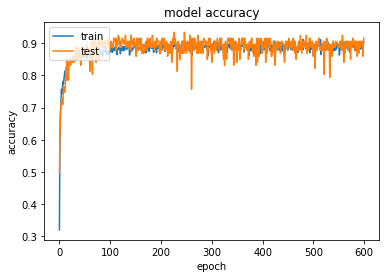

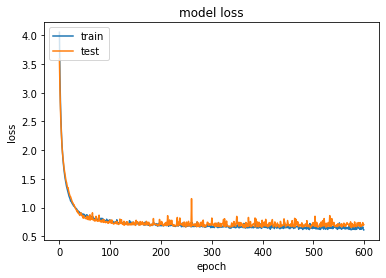

In [395]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Find the accuracy and build the confusion matrix using Neural Network.

 
Accuracy for Train Set: 0.908237747653806
Accuracy for Test Set: 0.8951310861423221


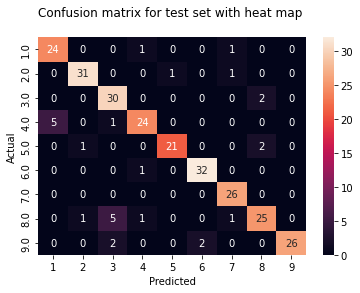

In [396]:
EcuIdentification_pred_NN = np.argmax(model.predict(EcuDataArray_TestScaled), axis=-1)
EcuIdentification_Train_pred_NN = np.argmax(model.predict(EcuDataArray_TrainScaled), axis=-1)

print(" ")
print("Accuracy for Train Set:", metrics.accuracy_score(EcuIdentification_train, EcuIdentification_Train_pred_NN))
print("Accuracy for Test Set:", metrics.accuracy_score(EcuIdentification_test, EcuIdentification_pred_NN))

# Confusion matrix of test set.
confusion_matrix = pd.crosstab(EcuIdentification_test, EcuIdentification_pred_NN, rownames=['Actual'], colnames=['Predicted'])
ax = sns.heatmap(confusion_matrix, annot=True)
ax.set(title = 'Confusion matrix for test set with heat map \n')
plt.show();

## Create classification report for neural network.

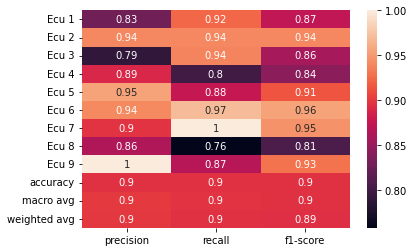

In [397]:
target_names = ["Ecu 1", "Ecu 2", "Ecu 3", "Ecu 4", "Ecu 5", "Ecu 6", "Ecu 7", "Ecu 8", "Ecu 9"]
# target_names = ["Ecu 1", "Ecu 2", "Ecu 3", "Ecu 4", "Ecu 5", "Ecu 6", "Ecu 7", "Ecu 8"]
clf_report = classification_report(EcuIdentification_test, EcuIdentification_pred_NN, 
                                   target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report). iloc[:-1, :].T, annot=True)
plt.show()

### Plot of actual signal from ECU 1

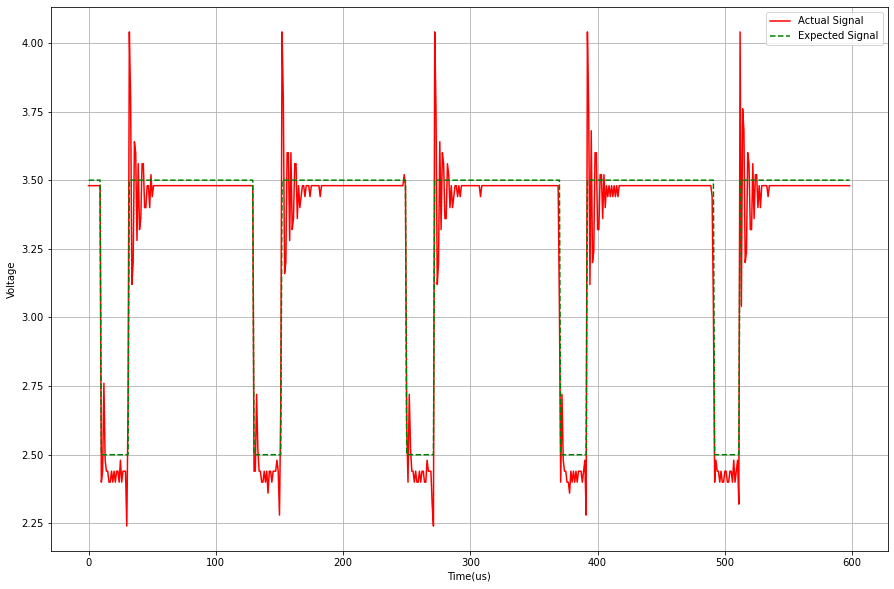

In [363]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu1.getTimeUs()[0], Ecu1.getVoltage()[0], 'r-', label="Actual Signal")
plt.plot(Ecu1.getTimeUs()[0], Ecu1.getExpectedVoltage()[0], 'g--', label="Expected Signal")
plt.xlabel("Time(us)")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

### Plot of simulated intrusion signal from ECU 9 (Derived from ECU 1 after adding gaussian noise.)

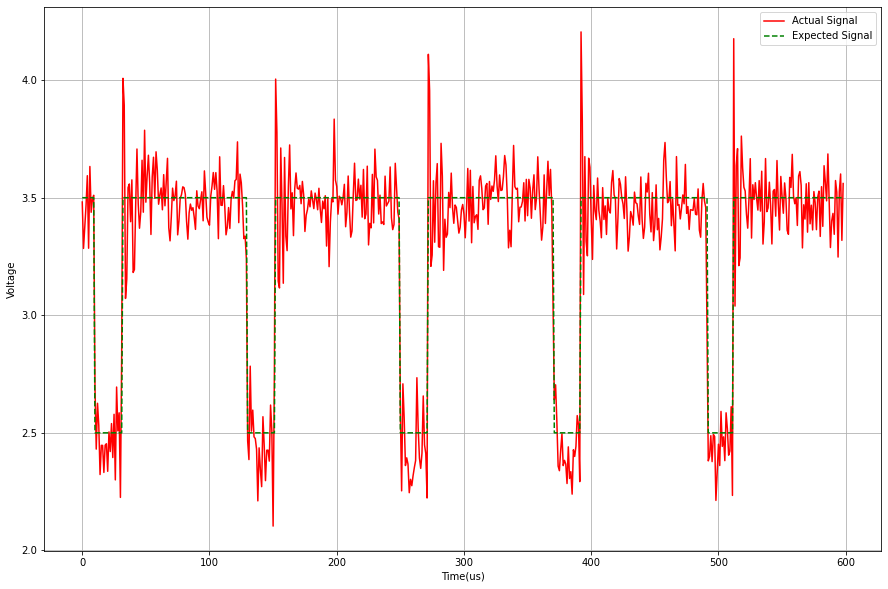

In [364]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu9.getTimeUs()[0], Ecu9.getVoltage()[0], 'r-', label="Actual Signal")
plt.plot(Ecu9.getTimeUs()[0], Ecu9.getExpectedVoltage()[0], 'g--', label="Expected Signal")
plt.xlabel("Time(us)")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

### Frequency signal of ECU 1 vs ECU 9 (Noise Added signal to ECU1) using fourier transform.

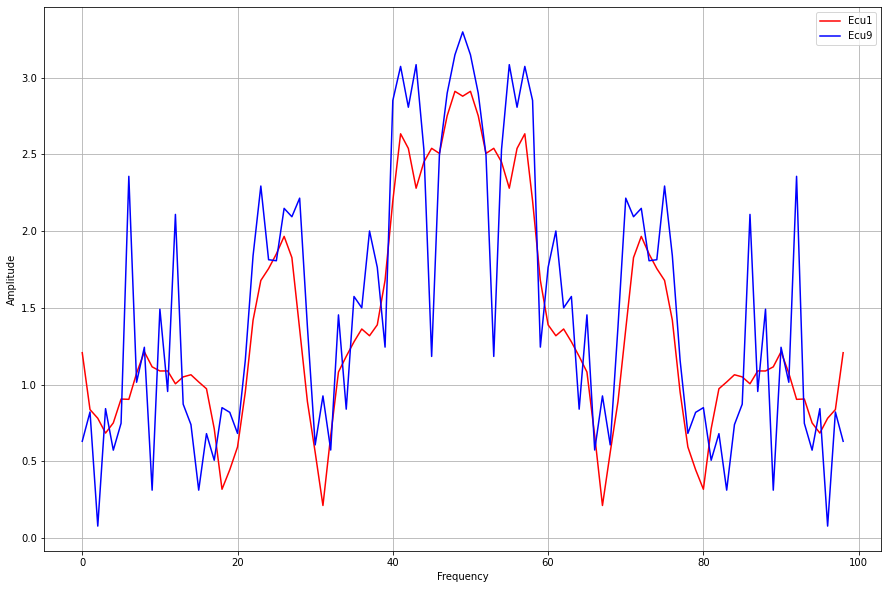

In [241]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu1.getFourierSignal()[5][1:], 'r-', label="Ecu1")
plt.plot(Ecu9.getFourierSignal()[5][1:], 'b-', label="Ecu9")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

### Peak Frequency feature using fourier transform.

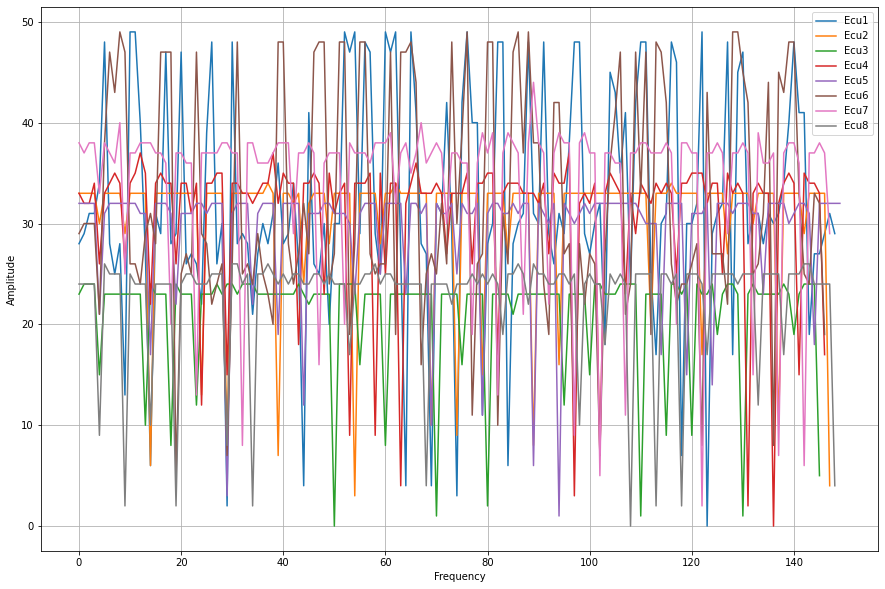

In [286]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu1.getPeakFreq(), label="Ecu1")
plt.plot(Ecu2.getPeakFreq(), label="Ecu2")
plt.plot(Ecu3.getPeakFreq(), label="Ecu3")
plt.plot(Ecu4.getPeakFreq(), label="Ecu4")
plt.plot(Ecu5.getPeakFreq(), label="Ecu5")
plt.plot(Ecu6.getPeakFreq(), label="Ecu6")
plt.plot(Ecu7.getPeakFreq(), label="Ecu7")
plt.plot(Ecu8.getPeakFreq(), label="Ecu8")
# plt.plot(Ecu9.getTimeUs()[0], Ecu9.getExpectedVoltage()[0], 'g--', label="Expected Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

### Least Frequency feature using fourier transform.

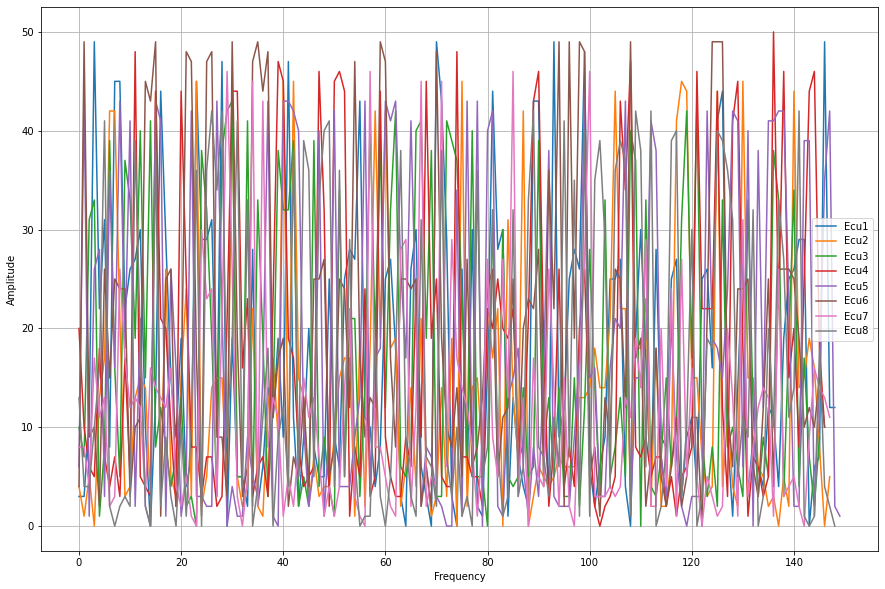

In [292]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu1.getLeastFreq(), label="Ecu1")
plt.plot(Ecu2.getLeastFreq(), label="Ecu2")
plt.plot(Ecu3.getLeastFreq(), label="Ecu3")
plt.plot(Ecu4.getLeastFreq(), label="Ecu4")
plt.plot(Ecu5.getLeastFreq(), label="Ecu5")
plt.plot(Ecu6.getLeastFreq(), label="Ecu6")
plt.plot(Ecu7.getLeastFreq(), label="Ecu7")
plt.plot(Ecu8.getLeastFreq(), label="Ecu8")
# plt.plot(Ecu9.getTimeUs()[0], Ecu9.getExpectedVoltage()[0], 'g--', label="Expected Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

### Peak Amplitude feature using fourier transform.

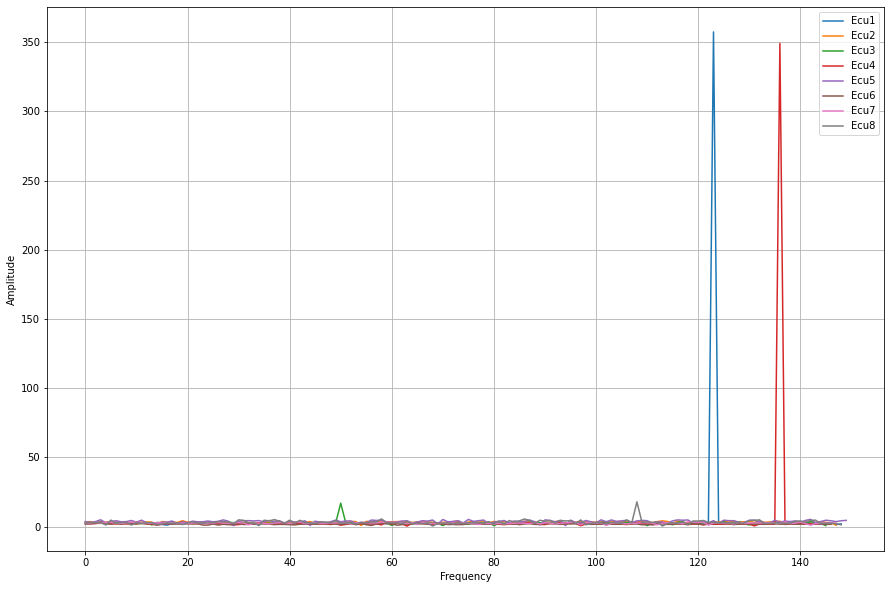

In [288]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu1.getPeakFreqAmplitude(), label="Ecu1")
plt.plot(Ecu2.getPeakFreqAmplitude(), label="Ecu2")
plt.plot(Ecu3.getPeakFreqAmplitude(), label="Ecu3")
plt.plot(Ecu4.getPeakFreqAmplitude(), label="Ecu4")
plt.plot(Ecu5.getPeakFreqAmplitude(), label="Ecu5")
plt.plot(Ecu6.getPeakFreqAmplitude(), label="Ecu6")
plt.plot(Ecu7.getPeakFreqAmplitude(), label="Ecu7")
plt.plot(Ecu8.getPeakFreqAmplitude(), label="Ecu8")
# plt.plot(Ecu9.getTimeUs()[0], Ecu9.getExpectedVoltage()[0], 'g--', label="Expected Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

### Least Amplitude feature using fourier transform.

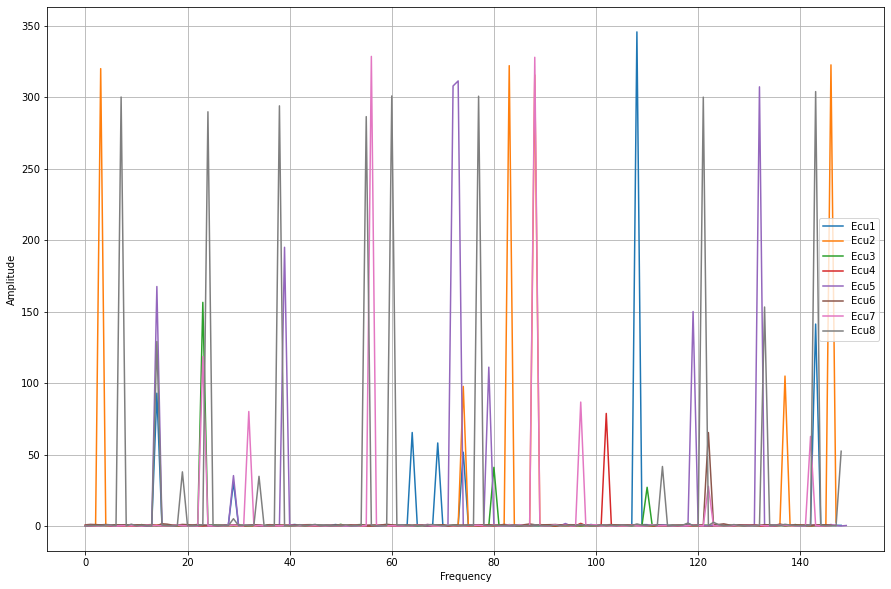

In [289]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu1.getLeastFreqAmplitude(), label="Ecu1")
plt.plot(Ecu2.getLeastFreqAmplitude(), label="Ecu2")
plt.plot(Ecu3.getLeastFreqAmplitude(), label="Ecu3")
plt.plot(Ecu4.getLeastFreqAmplitude(), label="Ecu4")
plt.plot(Ecu5.getLeastFreqAmplitude(), label="Ecu5")
plt.plot(Ecu6.getLeastFreqAmplitude(), label="Ecu6")
plt.plot(Ecu7.getLeastFreqAmplitude(), label="Ecu7")
plt.plot(Ecu8.getLeastFreqAmplitude(), label="Ecu8")
# plt.plot(Ecu9.getTimeUs()[0], Ecu9.getExpectedVoltage()[0], 'g--', label="Expected Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

### Least Frequency feature of ECU 1 vs ECU 9 using fourier transform.

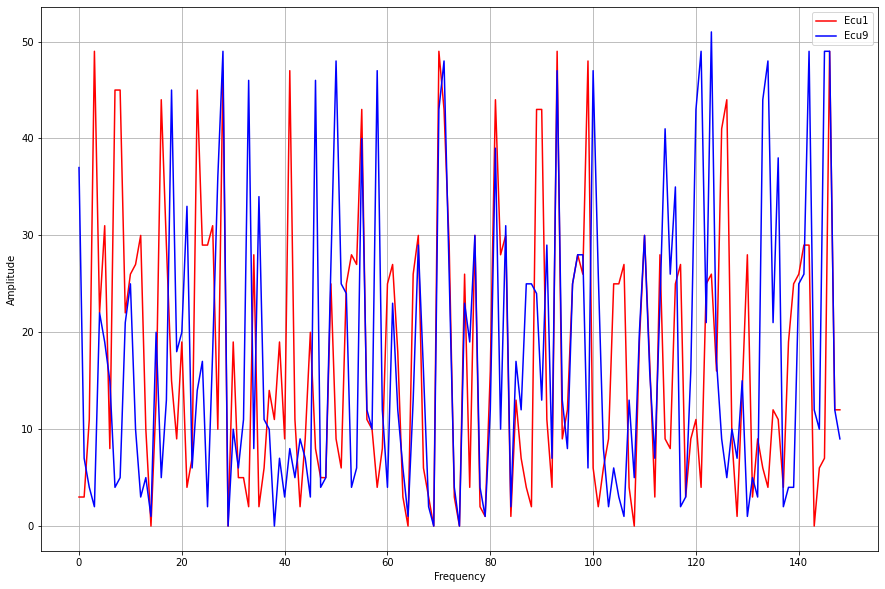

In [398]:
plt.figure(figsize=(15, 10))
plt.plot(Ecu1.getLeastFreq(), 'r-', label="Ecu1")
plt.plot(Ecu9.getLeastFreq(), 'b-', label="Ecu9")
# plt.plot(Ecu9.getTimeUs()[0], Ecu9.getExpectedVoltage()[0], 'g--', label="Expected Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

## Create histogram showing settling time max for all 8 ECUs and one intrusion simulated ECU.

### Graph of Model accuracy and loss vs epoch for train and test set.

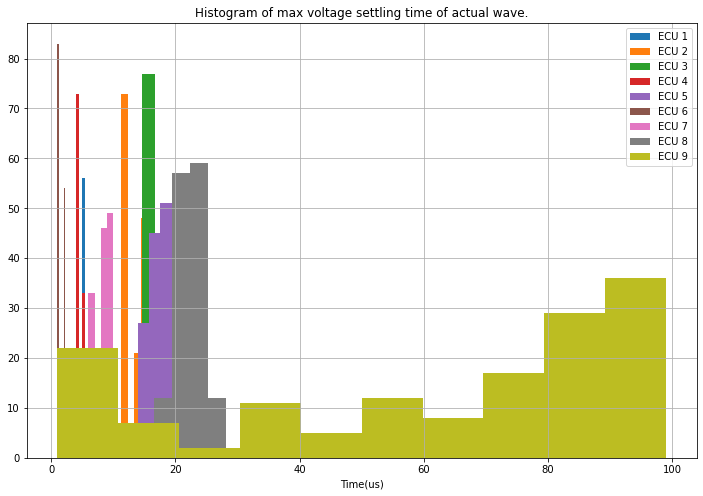

In [244]:
plt.figure(figsize=(12, 8))
plt.hist(np.array(Ecu1.getSettlingTimeMax()), label='ECU 1')
plt.hist(np.array(Ecu2.getSettlingTimeMax()), label='ECU 2')
plt.hist(np.array(Ecu3.getSettlingTimeMax()), label='ECU 3')
plt.hist(np.array(Ecu4.getSettlingTimeMax()), label='ECU 4')
plt.hist(np.array(Ecu5.getSettlingTimeMax()), label='ECU 5')
plt.hist(np.array(Ecu6.getSettlingTimeMax()), label='ECU 6')
plt.hist(np.array(Ecu7.getSettlingTimeMax()), label='ECU 7')
plt.hist(np.array(Ecu8.getSettlingTimeMax()), label='ECU 8')
plt.hist(np.array(Ecu9.getSettlingTimeMax()), label='ECU 9')
plt.title("Histogram of max voltage settling time of actual wave.")
plt.xlabel("Time(us)")
plt.legend()
plt.grid()
plt.show()

## Create histogram showing peak voltage for all 8 ECUs and one intrusion simulated ECU.

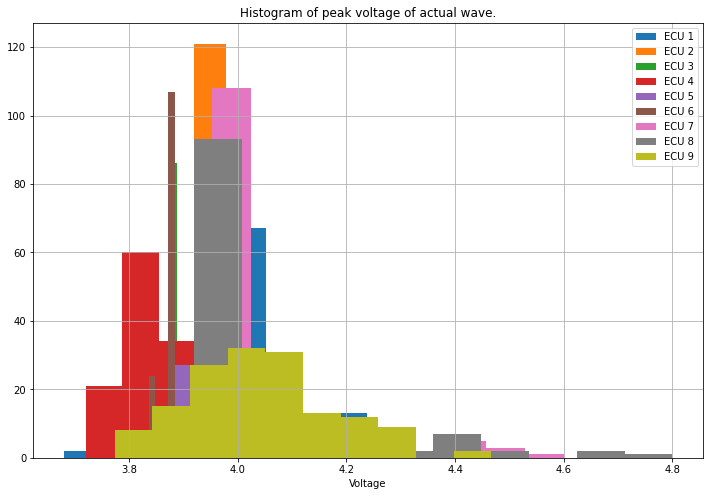

In [245]:
plt.figure(figsize=(12, 8))
plt.hist(np.array(Ecu1.getPeakVoltage()), label='ECU 1')
plt.hist(np.array(Ecu2.getPeakVoltage()), label='ECU 2')
plt.hist(np.array(Ecu3.getPeakVoltage()), label='ECU 3')
plt.hist(np.array(Ecu4.getPeakVoltage()), label='ECU 4')
plt.hist(np.array(Ecu5.getPeakVoltage()), label='ECU 5')
plt.hist(np.array(Ecu6.getPeakVoltage()), label='ECU 6')
plt.hist(np.array(Ecu7.getPeakVoltage()), label='ECU 7')
plt.hist(np.array(Ecu8.getPeakVoltage()), label='ECU 8')
plt.hist(np.array(Ecu9.getPeakVoltage()), label='ECU 9')
plt.title("Histogram of peak voltage of actual wave.")
plt.xlabel("Voltage")
plt.legend()
plt.grid()
plt.show()

## Create histogram showing lowest voltage for all 8 ECUs and one intrusion simulated ECU.

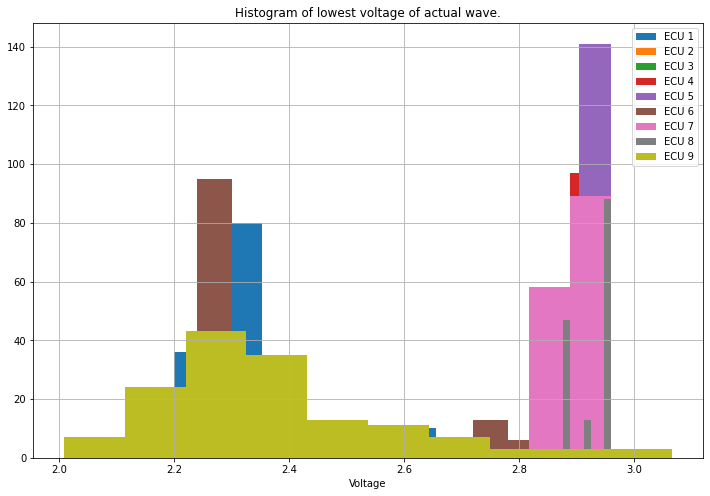

In [246]:
plt.figure(figsize=(12, 8))
plt.hist(np.array(Ecu1.getLowestVoltage()), label='ECU 1')
plt.hist(np.array(Ecu2.getLowestVoltage()), label='ECU 2')
plt.hist(np.array(Ecu3.getLowestVoltage()), label='ECU 3')
plt.hist(np.array(Ecu4.getLowestVoltage()), label='ECU 4')
plt.hist(np.array(Ecu5.getLowestVoltage()), label='ECU 5')
plt.hist(np.array(Ecu6.getLowestVoltage()), label='ECU 6')
plt.hist(np.array(Ecu7.getLowestVoltage()), label='ECU 7')
plt.hist(np.array(Ecu8.getLowestVoltage()), label='ECU 8')
plt.hist(np.array(Ecu9.getLowestVoltage()), label='ECU 9')
plt.title("Histogram of lowest voltage of actual wave.")
plt.xlabel("Voltage")
plt.legend()
plt.grid()
plt.show()